In [1]:
import pandas as pd
import numpy as np
from textwrap import shorten
from collections import deque
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import os
import glob
import re

In [ ]:
# --- ETAPA 1: CARREGAMENTO DOS ARQUIVOS ---
caminho_serie_a = 'dados/brasileiraoA/brasileiraoA2016.csv'
caminho_serie_b = 'dados/brasileiraoB/brasileiraoB2016.csv'
caminho_times = 'dados/times/times2016.csv'
caminho_copa_brasil = 'dados/copadobrasil/copadobrasil2016.csv'
caminho_libertadores = 'dados/libertadores/libertadores2016.csv'
try:
    df_serie_a = pd.read_csv(caminho_serie_a)
    df_serie_b = pd.read_csv(caminho_serie_b)
    df_times = pd.read_csv(caminho_times)
    
    # Carrega os arquivos de copa e mostra as colunas para debug
    df_copa_brasil = pd.read_csv(caminho_copa_brasil)
    df_libertadores = pd.read_csv(caminho_libertadores)
    
    print("✅ Arquivos CSV carregados com sucesso!")
    print(f"Colunas Copa do Brasil: {df_copa_brasil.columns.tolist()}")
    print(f"Colunas Libertadores: {df_libertadores.columns.tolist()}")
    print(f"Número de registros Copa do Brasil: {len(df_copa_brasil)}")
    print(f"Número de registros Libertadores: {len(df_libertadores)}")
    print(f"Número de registros Série A: {len(df_serie_a)}")
    print(f"Número de registros Série B: {len(df_serie_b)}")
    print(f"Número de registros Times: {len(df_times)}")
    
except FileNotFoundError as e:
    print(f"❌ Erro: Arquivo não encontrado! Verifique o caminho: {e.filename}")
    exit()

❌ Erro: Arquivo não encontrado! Verifique o caminho: dados/brasileiraoA/brasileiraoA2016.csv


: 

In [ ]:
# --- FUNÇÃO PARA PROCESSAR JOGOS DE COPA ---
def processar_jogos_copa(df_copa, competicao):
    """Processa os jogos de copa e retorna um dicionário com informações por time"""
    jogos_por_time = {}
    
    # Verifica os nomes das colunas e ajusta conforme necessário
    coluna_mandante = None
    coluna_visitante = None
    coluna_data = None
    coluna_fase = None
    
    # Mapeia possíveis nomes de colunas
    possiveis_colunas = {
        'mandante': ['Time Mandante', 'Mandante', 'Time da Casa', 'Casa'],
        'visitante': ['Time Visitante', 'Visitante', 'Time de Fora', 'Fora'],
        'data': ['Data', 'Date', 'Dia'],
        'fase': ['Fase', 'Phase', 'Stage', 'Rodada']
    }
    
    for col in df_copa.columns:
        col_lower = col.lower()
        if any(x.lower() in col_lower for x in possiveis_colunas['mandante']):
            coluna_mandante = col
        elif any(x.lower() in col_lower for x in possiveis_colunas['visitante']):
            coluna_visitante = col
        elif any(x.lower() in col_lower for x in possiveis_colunas['data']):
            coluna_data = col
        elif any(x.lower() in col_lower for x in possiveis_colunas['fase']):
            coluna_fase = col
    
    print(f"Processando {competicao}:")
    print(f"  Coluna Mandante: {coluna_mandante}")
    print(f"  Coluna Visitante: {coluna_visitante}")
    print(f"  Coluna Data: {coluna_data}")
    print(f"  Coluna Fase: {coluna_fase}")
    
    if not all([coluna_mandante, coluna_visitante, coluna_data]):
        print(f"❌ Colunas não encontradas em {competicao}")
        return jogos_por_time
    
    for _, jogo in df_copa.iterrows():
        try:
            # Converte a data para formato datetime (tenta diferentes formatos)
            data_str = str(jogo[coluna_data])
            data_jogo = None
            
            # Tenta diferentes formatos de data
            formatos_data = ['%d/%m/%y', '%d/%m/%Y', '%Y-%m-%d', '%m/%d/%Y']
            for formato in formatos_data:
                try:
                    data_jogo = datetime.strptime(data_str, formato)
                    break
                except ValueError:
                    continue
            
            if data_jogo is None:
                continue
            
            # Adiciona informações para o time mandante
            mandante = str(jogo[coluna_mandante]).strip()
            if mandante and mandante != 'nan':
                if mandante not in jogos_por_time:
                    jogos_por_time[mandante] = []
                
                fase = str(jogo[coluna_fase]).strip() if coluna_fase else 'F'
                jogos_por_time[mandante].append({
                    'data': data_jogo,
                    'competicao': competicao,
                    'fase': fase,
                    'adversario': str(jogo[coluna_visitante]).strip(),
                    'local': 'casa'
                })
            
            # Adiciona informações para o time visitante
            visitante = str(jogo[coluna_visitante]).strip()
            if visitante and visitante != 'nan':
                if visitante not in jogos_por_time:
                    jogos_por_time[visitante] = []
                
                fase = str(jogo[coluna_fase]).strip() if coluna_fase else 'F'
                jogos_por_time[visitante].append({
                    'data': data_jogo,
                    'competicao': competicao,
                    'fase': fase,
                    'adversario': str(jogo[coluna_mandante]).strip(),
                    'local': 'fora'
                })
            
        except (ValueError, KeyError) as e:
            continue
    
    return jogos_por_time

# Processa os jogos de copa
jogos_copa_brasil = processar_jogos_copa(df_copa_brasil, 'Copa do Brasil')
jogos_libertadores = processar_jogos_copa(df_libertadores, 'Libertadores')

# Combina os dois dicionários
todos_jogos_copa = {}
for time in set(list(jogos_copa_brasil.keys()) + list(jogos_libertadores.keys())):
    todos_jogos_copa[time] = (jogos_copa_brasil.get(time, []) + 
                             jogos_libertadores.get(time, []))

# Ordena os jogos por data para cada time
for time in todos_jogos_copa:
    todos_jogos_copa[time].sort(key=lambda x: x['data'])

# Mostra estatísticas dos jogos de copa processados
print(f"\n📊 Estatísticas dos jogos de copa processados:")
print(f"Times na Copa do Brasil: {len(jogos_copa_brasil)}")
print(f"Times na Libertadores: {len(jogos_libertadores)}")
print(f"Times totais com jogos de copa: {len(todos_jogos_copa)}")

Processando Copa do Brasil:
  Coluna Mandante: Time da Casa
  Coluna Visitante: Time Visitante
  Coluna Data: Data
  Coluna Fase: Rodada
Processando Libertadores:
  Coluna Mandante: Time da Casa
  Coluna Visitante: Time Visitante
  Coluna Data: Data
  Coluna Fase: Rodada

📊 Estatísticas dos jogos de copa processados:
Times na Copa do Brasil: 82
Times na Libertadores: 38
Times totais com jogos de copa: 115


In [ ]:
# 1. Caminho para a pasta onde estão os arquivos
caminho_pasta = 'simulacao2016/'

# 2. Busca todos os arquivos que começam com 'rodada' e terminam com '.csv'
# O '*' funciona como um coringa (wildcard)
arquivos_rodadas = glob.glob(os.path.join(caminho_pasta, 'rodada*.csv'))

# Ordenar os arquivos numericamente para garantir que a sequência esteja correta
# (Opcional, mas boa prática para conferência)
arquivos_rodadas.sort()

print(f"📂 Encontrados {len(arquivos_rodadas)} arquivos de rodada.")

# 3. Lista para armazenar os DataFrames de cada rodada
lista_dfs = []

for arquivo in arquivos_rodadas:
    try:
        df_temp = pd.read_csv(arquivo)
        # É sempre bom garantir que a coluna 'Rodada' exista e esteja correta
        # Se não tiver no CSV, você pode extrair do nome do arquivo
        lista_dfs.append(df_temp)
    except Exception as e:
        print(f"⚠️ Erro ao ler {arquivo}: {e}")

# 4. Concatenar (empilhar) todos os DataFrames em um só
df_serie_a_completo = pd.concat(lista_dfs, ignore_index=True)

# 5. Ordenar por rodada para o seu código de análise de features funcionar perfeitamente
df_serie_a_completo = df_serie_a_completo.sort_values(by='Rodada').reset_index(drop=True)

print(f"✅ Consolidação concluída! Total de jogos carregados: {len(df_serie_a_completo)}")
print(df_serie_a_completo)

📂 Encontrados 38 arquivos de rodada.
✅ Consolidação concluída! Total de jogos carregados: 532
     Jogo      Data  Time da Casa Time Visitante Serie  Rodada
0       1  13/05/16          Tupi          Goiás     B       1
1       2  14/05/16      Flamengo   Sport Recife     A       1
2       3  14/05/16     Palmeiras   Athletico-PR     A       1
3       4  14/05/16   Atlético-MG         Santos     A       1
4       5  14/05/16      Coritiba       Cruzeiro     A       1
..    ...       ...           ...            ...   ...     ...
527    11  11/12/16     São Paulo     Santa Cruz     A      38
528    14  11/12/16   Ponte Preta       Coritiba     A      38
529    13  11/12/16  Athletico-PR       Flamengo     A      38
530     6  11/12/16  Sport Recife    Figueirense     A      38
531     5  11/12/16    EC Vitória      Palmeiras     A      38

[532 rows x 6 columns]


In [ ]:
from collections import deque
import pandas as pd
import numpy as np

def gerar_features_completas(df_jogos, df_times):
    print("\n--- Integrando Sinais: Momentum, Força e Desespero ---")
    COLUNA_MANDANTE = 'Time da Casa'
    COLUNA_VISITANTE = 'Time Visitante'
    df_jogos = df_jogos.sort_values(by='Rodada').reset_index(drop=True)
    
    def extrair_gols(placar):
        try:
            gols = str(placar).replace('–', '-').split('-')
            return int(gols[0]), int(gols[1])
        except: return 0, 0
            
    df_jogos['Gols_Mandante'] = df_jogos['Placar'].apply(lambda p: extrair_gols(p)[0])
    df_jogos['Gols_Visitante'] = df_jogos['Placar'].apply(lambda p: extrair_gols(p)[1])
    
    media_gols_liga = df_jogos['Gols_Mandante'].mean() if not df_jogos.empty else 1.2
    
    try:
        df_jogos['Data_Datetime'] = pd.to_datetime(df_jogos['Data'], format='%d/%m/%y', errors='coerce')
    except:
        df_jogos['Data_Datetime'] = pd.to_datetime(df_jogos['Data'], errors='coerce')
    
    mapa_time_regiao = df_times.set_index('time')['região'].to_dict()
    unique_teams = pd.concat([df_jogos[COLUNA_MANDANTE], df_jogos[COLUNA_VISITANTE]]).unique()
    
    stats_times = {time: {
        'pontos': 0, 'jogos': 0, 'vitorias': 0, 'sg_casa': 0, 'sg_fora': 0,
        'gols_marcados_casa': 0, 'gols_sofridos_casa': 0, 'jogos_casa': 0,
        'gols_marcados_fora': 0, 'gols_sofridos_fora': 0, 'jogos_fora': 0,
        'ultimos_5_saldos_casa': deque(maxlen=5),
        'ultimos_5_saldos_fora': deque(maxlen=5),
        'ultimos_5_resultados': deque(maxlen=5)
    } for time in unique_teams}
    
    listas_features = {
        'Posicao_Mandante': [], 'Posicao_Visitante': [],
        'Media_GM_Casa': [], 'Media_GS_Casa': [],
        'Media_GM_Fora': [], 'Media_GS_Fora': [],
        'Saldo_Gols_Casa_Mandante': [], 'Saldo_Gols_Fora_Visitante': [],
        'Saldo_Ultimos_5_Casa_Mandante': [], 'Saldo_Ultimos_5_Fora_Visitante': [],
        'Sequencia_5_Mandante': [], 'Sequencia_5_Visitante': [],
        'Proxima_Copa_Mandante': [], 'Proxima_Copa_Visitante': [],
        'Forca_Atk_M': [], 'Forca_Def_V': [], 'Sinal_Dominio': [],
        'Momentum_M': [], 'Momentum_V': [],
        'Desespero_Mandante': [], 'Desespero_Visitante': [], 'Delta_Desespero': [],
        'Soberba_Mandante': [], 'Soberba_Visitante': [], 'Delta_Soberba': [],
    }

    def calcular_momentum_ia(deque_resultados):
        if not deque_resultados: return 0
        pontos_map = {'V': 3, 'E': 1, 'D': 0}
        vals = [pontos_map.get(res, 0) for res in deque_resultados]
        pesos = range(1, len(vals) + 1)
        return sum(v * p for v, p in zip(vals, pesos)) / sum(pesos)
    
    for rodada in range(1, 39):
        df_classificacao = pd.DataFrame.from_dict(stats_times, orient='index')
        df_classificacao['sg_total'] = df_classificacao['sg_casa'] + df_classificacao['sg_fora']
        df_classificacao = df_classificacao.sort_values(by=['pontos', 'vitorias', 'sg_total'], ascending=False)
        df_classificacao['posicao'] = range(1, len(df_classificacao) + 1)
        mapa_posicao = df_classificacao['posicao'].to_dict()
        
        jogos_da_rodada = df_jogos[df_jogos['Rodada'] == rodada]
        
        for index, jogo in jogos_da_rodada.iterrows():
            mandante, visitante = jogo[COLUNA_MANDANTE], jogo[COLUNA_VISITANTE]
            data_jogo = jogo['Data_Datetime']
            if pd.isna(data_jogo): continue
            
            stats_m, stats_v = stats_times[mandante], stats_times[visitante]
            
            # --- CÁLCULO DAS FEATURES (ANTES DO JOGO) ---
            pos_m = mapa_posicao.get(mandante, 21)
            pos_v = mapa_posicao.get(visitante, 21)
            listas_features['Posicao_Mandante'].append(pos_m)
            listas_features['Posicao_Visitante'].append(pos_v)
            
            # --- FEATURE: DESESPERO ---
            def calcular_desespero(pos, rd):
                if rd < 10: return 0
                urgencia = 0
                if pos <= 3: urgencia = 1.0       # Título
                elif pos <= 8: urgencia = 0.7     # Libertadores
                elif pos >= 17: urgencia = 1.2    # REBAIXAMENTO
                elif pos >= 14: urgencia = 0.5    # Alerta
                return urgencia * (rd / 38)

            d_m = calcular_desespero(pos_m, rodada)
            d_v = calcular_desespero(pos_v, rodada)
            listas_features['Desespero_Mandante'].append(d_m)
            listas_features['Desespero_Visitante'].append(d_v)
            listas_features['Delta_Desespero'].append(d_m - d_v)
            
            
               
            # Médias e Forças
            mgm_c = stats_m['gols_marcados_casa'] / stats_m['jogos_casa'] if stats_m['jogos_casa'] > 0 else 0
            mgs_f = stats_v['gols_sofridos_fora'] / stats_v['jogos_fora'] if stats_v['jogos_fora'] > 0 else 0
            
            listas_features['Media_GM_Casa'].append(mgm_c)
            listas_features['Media_GS_Casa'].append(stats_m['gols_sofridos_casa'] / stats_m['jogos_casa'] if stats_m['jogos_casa'] > 0 else 0)
            listas_features['Media_GM_Fora'].append(stats_v['gols_marcados_fora'] / stats_v['jogos_fora'] if stats_v['jogos_fora'] > 0 else 0)
            listas_features['Media_GS_Fora'].append(mgs_f)
            
            listas_features['Saldo_Gols_Casa_Mandante'].append(stats_m['sg_casa'])
            listas_features['Saldo_Gols_Fora_Visitante'].append(stats_v['sg_fora'])
            listas_features['Saldo_Ultimos_5_Casa_Mandante'].append(sum(stats_m['ultimos_5_saldos_casa']))
            listas_features['Saldo_Ultimos_5_Fora_Visitante'].append(sum(stats_v['ultimos_5_saldos_fora']))
            
            listas_features['Sequencia_5_Mandante'].append(''.join(stats_m['ultimos_5_resultados']) or '-')
            listas_features['Sequencia_5_Visitante'].append(''.join(stats_v['ultimos_5_resultados']) or '-')

            # Sinais de Força
            f_atk = mgm_c / media_gols_liga
            f_def = mgs_f / media_gols_liga
            listas_features['Forca_Atk_M'].append(f_atk)
            listas_features['Forca_Def_V'].append(f_def)
            listas_features['Sinal_Dominio'].append(f_atk * f_def)
            listas_features['Momentum_M'].append(calcular_momentum_ia(stats_m['ultimos_5_resultados']))
            listas_features['Momentum_V'].append(calcular_momentum_ia(stats_v['ultimos_5_resultados']))

            # Lógica de Copa
            def get_proxima_copa(time, data_atual):
                if 'todos_jogos_copa' in globals() and time in todos_jogos_copa:
                    proximos = [j for j in todos_jogos_copa[time] if j['data'] > data_atual]
                    if proximos:
                        prox = min(proximos, key=lambda x: x['data'])
                        if (prox['data'] - data_atual).days <= 7:
                            return f"{prox['competicao'][0]}{prox['fase'][0]}"
                return '-'
            
            listas_features['Proxima_Copa_Mandante'].append(get_proxima_copa(mandante, data_jogo))
            listas_features['Proxima_Copa_Visitante'].append(get_proxima_copa(visitante, data_jogo))
            
            def calcular_soberba(tem_copa, pos_time, pos_adv):
                if tem_copa == 0: return 0
                
                # Só há risco de soberba se o time for muito superior (ex: 10 posições de diferença)
                gap_tabela = pos_adv - pos_time
                if gap_tabela > 0:
                    # Quanto maior o gap e mais perto do fim, maior o risco de poupar
                    sinal = (gap_tabela / 20) ** 2
                    return sinal * (rodada / 38)
                return 0

            # Pegamos os dados de Copa que já calculamos antes
            c_m = 1 if listas_features['Proxima_Copa_Mandante'][-1] != '-' else 0
            c_v = 1 if listas_features['Proxima_Copa_Visitante'][-1] != '-' else 0
            
            sob_m = calcular_soberba(c_m, pos_m, pos_v)
            sob_v = calcular_soberba(c_v, pos_v, pos_m)
            
            listas_features['Soberba_Mandante'].append(sob_m)
            listas_features['Soberba_Visitante'].append(sob_v)
            listas_features['Delta_Soberba'].append(sob_m - sob_v)
            
            # --- ATUALIZAÇÃO PÓS-JOGO ---
            g_m, g_v = jogo['Gols_Mandante'], jogo['Gols_Visitante']
            res_m, res_v = ('V','D') if g_m > g_v else (('D','V') if g_v > g_m else ('E','E'))
            stats_m['ultimos_5_saldos_casa'].append(g_m - g_v); stats_v['ultimos_5_saldos_fora'].append(g_v - g_m)
            stats_m['ultimos_5_resultados'].append(res_m); stats_v['ultimos_5_resultados'].append(res_v)
            
            stats_m.update({'jogos_casa': stats_m['jogos_casa']+1, 'gols_marcados_casa': stats_m['gols_marcados_casa']+g_m, 'gols_sofridos_casa': stats_m['gols_sofridos_casa']+g_v, 'sg_casa': stats_m['sg_casa']+(g_m-g_v)})
            stats_v.update({'jogos_fora': stats_v['jogos_fora']+1, 'gols_marcados_fora': stats_v['gols_marcados_fora']+g_v, 'gols_sofridos_fora': stats_v['gols_sofridos_fora']+g_m, 'sg_fora': stats_v['sg_fora']+(g_v-g_m)})
            if g_m > g_v: stats_m['pontos'] += 3; stats_m['vitorias'] += 1
            elif g_v > g_m: stats_v['pontos'] += 3; stats_v['vitorias'] += 1
            else: stats_m['pontos'] += 1; stats_v['pontos'] += 1

    # Adiciona tudo ao DataFrame final
    # 1. Atribuição de todas as listas acumuladas para o DataFrame
    for nome, lista in listas_features.items():
        if len(lista) == len(df_jogos):
            df_jogos[nome] = lista
        else:
            # Debug caso as listas tenham tamanhos diferentes (ajuda a achar erros de loop)
            print(f"⚠️ Aviso: Coluna {nome} com tamanho {len(lista)} diferente do DF {len(df_jogos)}")

    # 2. Cálculos Derivados (Sincronização Final)
    df_jogos['Diferenca_Posicao'] = df_jogos['Posicao_Mandante'] - df_jogos['Posicao_Visitante']
    df_jogos['Equilibrio_Posicao'] = (abs(df_jogos['Diferenca_Posicao']) <= 3).astype(int)
    df_jogos['Jogo_de_6_Pontos'] = (abs(df_jogos['Diferenca_Posicao']) <= 4).astype(int)
    
    # Diferencial de Fase (Momentum)
    df_jogos['Delta_Momentum'] = df_jogos['Momentum_M'] - df_jogos['Momentum_V']
    
    # Diferencial de Emoção (Desespero)
    # Garante que as colunas individuais existam antes de calcular o Delta
    df_jogos['Desespero_Mandante'] = listas_features['Desespero_Mandante']
    df_jogos['Desespero_Visitante'] = listas_features['Desespero_Visitante']
    df_jogos['Delta_Desespero'] = df_jogos['Desespero_Mandante'] - df_jogos['Desespero_Visitante']
    df_jogos['Soberba_Mandante'] = listas_features['Soberba_Mandante']
    df_jogos['Soberba_Visitante'] = listas_features['Soberba_Visitante']
    df_jogos['Delta_Soberba'] = df_jogos['Soberba_Mandante'] - df_jogos['Soberba_Visitante']

    # Sensores de Força Relativa
    df_jogos['Soma_Forca_Atk_Def'] = df_jogos['Forca_Atk_M'] + df_jogos['Forca_Def_V']
    df_jogos['Produto_Forca_Atk_Def'] = df_jogos['Forca_Atk_M'] * df_jogos['Forca_Def_V']
    df_jogos['Diferenca_Forca_Atk_Def'] = abs(df_jogos['Forca_Atk_M'] - df_jogos['Forca_Def_V'])
    
    # Clássico Regional
    df_jogos['É_Clássico'] = (df_jogos[COLUNA_MANDANTE].map(mapa_time_regiao) == 
                              df_jogos[COLUNA_VISITANTE].map(mapa_time_regiao)).astype(int)
    
    print(f"✅ Sucesso! DF finalizado com {len(df_jogos.columns)} colunas.")
    return df_jogos

In [ ]:
def preparar_para_xgboost(df):
    df_ml = df.copy()

    # 1. Variável Alvo (Target)
    def definir_alvo(row):
        if row['Gols_Mandante'] > row['Gols_Visitante']: return 1
        if row['Gols_Mandante'] < row['Gols_Visitante']: return 2
        return 0
    
    df_ml['Target'] = df_ml.apply(definir_alvo, axis=1)

    # 2. Conversões de Sequência e Copa
    def converter_sequencia(seq):
        if seq == '-' or pd.isna(seq): return 0
        mapa_pts = {'V': 3, 'E': 1, 'D': 0}
        return sum(mapa_pts.get(resultado, 0) for resultado in seq)

    df_ml['Pts_Ultimos_5_M'] = df_ml['Sequencia_5_Mandante'].apply(converter_sequencia)
    df_ml['Pts_Ultimos_5_V'] = df_ml['Sequencia_5_Visitante'].apply(converter_sequencia)
    df_ml['Tem_Copa_M'] = (df_ml['Proxima_Copa_Mandante'] != '-').astype(int)
    df_ml['Tem_Copa_V'] = (df_ml['Proxima_Copa_Visitante'] != '-').astype(int)

    # 3. LISTA FINAL DE RECURSOS (30 Sensores)
    colunas_finais = [
        'Rodada', 'Posicao_Mandante', 'Posicao_Visitante', 'Diferenca_Posicao',
        'Media_GM_Casa', 'Media_GS_Casa', 'Media_GM_Fora', 'Media_GS_Fora',
        'Saldo_Gols_Casa_Mandante', 'Saldo_Gols_Fora_Visitante',
        'Saldo_Ultimos_5_Casa_Mandante', 'Saldo_Ultimos_5_Fora_Visitante',
        'Pts_Ultimos_5_M', 'Pts_Ultimos_5_V',
        'Tem_Copa_M', 'Tem_Copa_V', 'É_Clássico', 'Jogo_de_6_Pontos',
        
        # --- NOVOS SINAIS (O "SINAL LIMPO") ---
        'Forca_Atk_M', 'Forca_Def_V', 'Sinal_Dominio', 
        'Momentum_M', 'Momentum_V', 'Delta_Momentum',
        'Soma_Forca_Atk_Def', 'Produto_Forca_Atk_Def', 'Diferenca_Forca_Atk_Def', # <-- VÍRGULA CORRIGIDA AQUI
        'Desespero_Mandante', 'Desespero_Visitante', 'Delta_Desespero',
        'Soberba_Mandante', 'Soberba_Visitante', 'Delta_Soberba'
    ]

    # 4. Limpeza e Matriz Final
    X = df_ml[colunas_finais].fillna(0)
    y = df_ml['Target']

    return X, y

# --- EXECUÇÃO DO FLUXO ---
# 1. Carrega os dados
df_bruto_a = pd.read_csv(caminho_serie_a)
df_bruto_b = pd.read_csv(caminho_serie_b)

# 2. Gera as features (Sinal de 74.8% + Desespero)
df_enriquecido_a = gerar_features_completas(df_bruto_a, df_times)
df_enriquecido_b = gerar_features_completas(df_bruto_b, df_times)

# 3. Une as bases
df_total_enriquecido = pd.concat([df_enriquecido_a, df_enriquecido_b], ignore_index=True)
print(f"✅ Base unificada com {len(df_total_enriquecido)} jogos.")

# 4. Prepara para o Treino
X, y = preparar_para_xgboost(df_total_enriquecido)
print("🚀 Matriz de 30 sensores pronta para o XGBoost!")


--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF finalizado com 41 colunas.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF finalizado com 41 colunas.
✅ Base unificada com 761 jogos.
🚀 Matriz de 30 sensores pronta para o XGBoost!


In [ ]:
# --- Treino ---
modelo_loteca = xgb.XGBClassifier(max_depth=4, learning_rate=0.05)
modelo_loteca.fit(X, y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

# 1. Definimos os dois "especialistas"
modelo_xgb = XGBClassifier(
    n_estimators=200, 
    max_depth=5, 
    learning_rate=0.05, 
    objective='multi:softprob',
    random_state=42
)

modelo_rf = RandomForestClassifier(
    n_estimators=300, 
    max_depth=10, 
    min_samples_leaf=5,
    random_state=42
)

# 2. Criamos o Comitê (Voting)
# O 'soft' significa que eles vão somar as probabilidades antes de decidir
comite_loteca = VotingClassifier(
    estimators=[
        ('xgb', modelo_xgb), 
        ('rf', modelo_rf)
    ],
    voting='soft' 
)

# 3. Treino com as suas 33 features
print("🧠 Treinando o comitê com as 33 features...")
comite_loteca.fit(X, y)
print("✅ Comitê pronto para a ação!")

🧠 Treinando o comitê com as 33 features...
✅ Comitê pronto para a ação!


In [ ]:
from sklearn.metrics import accuracy_score

# Fazendo a previsão nos mesmos dados de treino
pred_treino = modelo_loteca.predict(X)
acuracia = accuracy_score(y, pred_treino)

print(f"📊 Acurácia no treino: {acuracia:.2%}")

In [ ]:
pred_treino = comite_loteca.predict(X)
acuracia = accuracy_score(y, pred_treino)

print(f"📊 Acurácia no treino: {acuracia:.2%}")

📊 Acurácia no treino: 97.90%


Testar a IA


In [ ]:
import numpy as np

modelo = comite_loteca  # Usando o modelo treinado anteriormente

def converter_sequencia(seq):
    if seq == '-': return 0
    mapa_pts = {'V': 3, 'E': 1, 'D': 0}
    return sum(mapa_pts.get(resultado, 0) for resultado in seq)
    
def testar_rodada_especifica(caminho_csv, df_treino_total):
    # 1. Carregar a rodada sorteada
    df_rodada = pd.read_csv(caminho_csv)
    
    palpites = []
    print(f"🧐 Analisando os 14 jogos de: {caminho_csv}\n")
    print(f"{'JOGO':<4} | {'MANDANTE':<15} | {'VISITANTE':<15} | {'PALPITE':<7} | {'CONFIANÇA'}")
    print("-" * 70)

    # 2. Iterar pelos 14 jogos do bilhete
    for i, jogo in df_rodada.iterrows():
        mandante = jogo['Time da Casa']
        visitante = jogo['Time Visitante']

        # BUSCA: Pegamos os dados mais recentes desses times na nossa base de treino
        # Filtramos por jogos que aconteceram ANTES da rodada atual para não "roubar"
        stats_m = df_treino_total[df_treino_total['Time da Casa'] == mandante].tail(1)
        stats_v = df_treino_total[df_treino_total['Time Visitante'] == visitante].tail(1)

        if not stats_m.empty and not stats_v.empty:
            # Construímos a linha de entrada EXATAMENTE como a IA aprendeu
            # Construímos a linha de entrada EXATAMENTE como a IA aprendeu
            input_ia = pd.DataFrame([{
                'Rodada': jogo['Rodada'],
                'Posicao_Mandante': stats_m['Posicao_Mandante'].values[0],
                'Posicao_Visitante': stats_v['Posicao_Visitante'].values[0],
                'Diferenca_Posicao': stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0],
                'Media_GM_Casa': stats_m['Media_GM_Casa'].values[0],
                'Media_GS_Casa': stats_m['Media_GS_Casa'].values[0],
                'Media_GM_Fora': stats_v['Media_GM_Fora'].values[0],
                'Media_GS_Fora': stats_v['Media_GS_Fora'].values[0],
                'Saldo_Gols_Casa_Mandante': stats_m['Saldo_Gols_Casa_Mandante'].values[0],
                'Saldo_Gols_Fora_Visitante': stats_v['Saldo_Gols_Fora_Visitante'].values[0],
                'Saldo_Ultimos_5_Casa_Mandante': stats_m['Saldo_Ultimos_5_Casa_Mandante'].values[0],
                'Saldo_Ultimos_5_Fora_Visitante': stats_v['Saldo_Ultimos_5_Fora_Visitante'].values[0],
                'Pts_Ultimos_5_M': converter_sequencia(stats_m['Sequencia_5_Mandante'].values[0]),
                'Pts_Ultimos_5_V': converter_sequencia(stats_v['Sequencia_5_Visitante'].values[0]),
                'Tem_Copa_M': 1 if stats_m['Proxima_Copa_Mandante'].values[0] != '-' else 0,
                'Tem_Copa_V': 1 if stats_v['Proxima_Copa_Visitante'].values[0] != '-' else 0,
                'É_Clássico': jogo['É_Clássico'] if 'É_Clássico' in jogo else 0,
                'Jogo_de_6_Pontos': 1 if abs(stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0]) <= 4 else 0,
                
                # --- NOVAS FEATURES (CORRIGIDAS PARA MAIÚSCULAS) ---
                'Forca_Atk_M': stats_m['Forca_Atk_M'].values[0],
                'Forca_Def_V': stats_v['Forca_Def_V'].values[0],
                'Sinal_Dominio': stats_m['Sinal_Dominio'].values[0],
                'Momentum_M': stats_m['Momentum_M'].values[0],
                'Momentum_V': stats_v['Momentum_V'].values[0],
                'Delta_Momentum': stats_m['Momentum_M'].values[0] - stats_v['Momentum_V'].values[0],
                'Soma_Forca_Atk_Def': stats_m['Soma_Forca_Atk_Def'].values[0],
                'Produto_Forca_Atk_Def': stats_m['Produto_Forca_Atk_Def'].values[0],
                'Diferenca_Forca_Atk_Def':  abs(stats_m['Forca_Atk_M'].values[0] - stats_v['Forca_Def_V'].values[0]),
                'Desespero_Mandante': stats_m['Desespero_Mandante'].values[0],
                'Desespero_Visitante': stats_v['Desespero_Visitante'].values[0],
                'Delta_Desespero': stats_m['Delta_Desespero'].values[0],
                'Soberba_Mandante': stats_m['Soberba_Mandante'].values[0],
                'Soberba_Visitante': stats_v['Soberba_Visitante'].values[0],
                'Delta_Soberba': stats_m['Delta_Soberba'].values[0]
            }])

            # 3. Predição
            # Pegamos as probabilidades: [Empate, Casa, Fora]
            probs = modelo.predict_proba(input_ia)[0]
            classe_predita = np.argmax(probs)
            confianca = probs[classe_predita]
            
            mapa_res = {1: "CASA", 0: "EMPATE", 2: "FORA"}
            palpite = mapa_res[classe_predita]
            
            print(f"{i+1:>4} | {mandante:<15} | {visitante:<15} | {palpite:<7} | {confianca:.1%}")
        else:
            print(f"{i+1:>4} | {mandante:<15} | {visitante:<15} | SEM DADOS PARA ANÁLISE")

# Executar o teste na Rodada 14
# Lembre de passar o DataFrame que você unificou (A+B) para a busca
testar_rodada_especifica('simulacao2016/rodada14.csv', df_total_enriquecido)

🧐 Analisando os 14 jogos de: simulacao2016/rodada14.csv

JOGO | MANDANTE        | VISITANTE       | PALPITE | CONFIANÇA
----------------------------------------------------------------------
   1 | Sampaio Corrêa  | Paysandu        | CASA    | 68.2%
   2 | Luverdense      | Oeste           | CASA    | 63.6%
   3 | CRB             | Goiás           | CASA    | 58.8%
   4 | Brasil de Pelotas | Joinville       | CASA    | 69.0%
   5 | Chapecoense     | Corinthians     | CASA    | 57.9%
   6 | Coritiba        | Botafogo        | CASA    | 52.4%
   7 | Ponte Preta     | Sport Recife    | CASA    | 59.0%
   8 | Flamengo        | Atlético-MG     | CASA    | 53.2%
   9 | Grêmio          | Figueirense     | CASA    | 63.9%
  10 | São Paulo       | América-MG      | CASA    | 70.4%
  11 | Santa Cruz      | Internacional   | CASA    | 44.4%
  12 | EC Vitória      | Fluminense      | CASA    | 35.3%
  13 | Cruzeiro        | Athletico-PR    | CASA    | 60.6%
  14 | Palmeiras       | Santos         

In [ ]:
def validar_loteca_com_gabarito(caminho_concurso, df_gabarito):
    # 1. Carrega o bilhete (os 14 jogos sorteados)
    df_concurso = pd.read_csv(caminho_concurso)
    
    acertos = 0
    jogos_processados = 0
    
    print(f"🏟️  CONFERINDO BILHETE: {caminho_concurso}")
    print(f"{'JOGO':<4} | {'MANDANTE':<15} | {'VISITANTE':<15} | {'IA':<7} | {'REAL':<7} | {'STATUS'}")
    print("-" * 80)

    mapa_res = {1: "CASA", 0: "EMPATE", 2: "FORA"}

    for i, jogo in df_concurso.iterrows():
        m = jogo['Time da Casa']
        v = jogo['Time Visitante']

        # --- BUSCA O RESULTADO REAL NO GABARITO ---
        # Procuramos o jogo exato entre esses dois times no seu DF completo
        jogo_real = df_gabarito[(df_gabarito['Time da Casa'] == m) & 
                                (df_gabarito['Time Visitante'] == v)]
        
        if jogo_real.empty:
            print(f"{i+1:>4} | {m[:15]:<15} | {v[:15]:<15} | --- SEM GABARITO ---")
            continue

        # Extrai o placar e transforma em 0, 1 ou 2
        g_m = jogo_real['Gols_Mandante'].values[0]
        g_v = jogo_real['Gols_Visitante'].values[0]
        
        if g_m > g_v: real_num = 1
        elif g_v > g_m: real_num = 2
        else: real_num = 0

        # --- PREPARA OS DADOS PARA A IA (MESMA LÓGICA ANTERIOR) ---
        # Pegamos as estatísticas da ÚLTIMA vez que esses times jogaram (antes desse jogo)
        stats_m = df_gabarito[(df_gabarito['Time da Casa'] == m) | (df_gabarito['Time Visitante'] == m)].tail(1)
        stats_v = df_gabarito[(df_gabarito['Time da Casa'] == v) | (df_gabarito['Time Visitante'] == v)].tail(1)

        # Monta o vetor de entrada para o XGBoost
        input_ia = pd.DataFrame([{
                'Rodada': jogo['Rodada'],
                'Posicao_Mandante': stats_m['Posicao_Mandante'].values[0],
                'Posicao_Visitante': stats_v['Posicao_Visitante'].values[0],
                'Diferenca_Posicao': stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0],
                'Media_GM_Casa': stats_m['Media_GM_Casa'].values[0],
                'Media_GS_Casa': stats_m['Media_GS_Casa'].values[0],
                'Media_GM_Fora': stats_v['Media_GM_Fora'].values[0],
                'Media_GS_Fora': stats_v['Media_GS_Fora'].values[0],
                'Saldo_Gols_Casa_Mandante': stats_m['Saldo_Gols_Casa_Mandante'].values[0],
                'Saldo_Gols_Fora_Visitante': stats_v['Saldo_Gols_Fora_Visitante'].values[0],
                'Saldo_Ultimos_5_Casa_Mandante': stats_m['Saldo_Ultimos_5_Casa_Mandante'].values[0],
                'Saldo_Ultimos_5_Fora_Visitante': stats_v['Saldo_Ultimos_5_Fora_Visitante'].values[0],
                'Pts_Ultimos_5_M': converter_sequencia(stats_m['Sequencia_5_Mandante'].values[0]),
                'Pts_Ultimos_5_V': converter_sequencia(stats_v['Sequencia_5_Visitante'].values[0]),
                'Tem_Copa_M': 1 if stats_m['Proxima_Copa_Mandante'].values[0] != '-' else 0,
                'Tem_Copa_V': 1 if stats_v['Proxima_Copa_Visitante'].values[0] != '-' else 0,
                'É_Clássico': jogo['É_Clássico'] if 'É_Clássico' in jogo else 0,
                'Jogo_de_6_Pontos': 1 if abs(stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0]) <= 4 else 0,
                
                # --- NOVAS FEATURES (CORRIGIDAS PARA MAIÚSCULAS) ---
                'Forca_Atk_M': stats_m['Forca_Atk_M'].values[0],
                'Forca_Def_V': stats_v['Forca_Def_V'].values[0],
                'Sinal_Dominio': stats_m['Sinal_Dominio'].values[0],
                'Momentum_M': stats_m['Momentum_M'].values[0],
                'Momentum_V': stats_v['Momentum_V'].values[0],
                'Delta_Momentum': stats_m['Momentum_M'].values[0] - stats_v['Momentum_V'].values[0],
                'Soma_Forca_Atk_Def': stats_m['Soma_Forca_Atk_Def'].values[0],
                'Produto_Forca_Atk_Def': stats_m['Produto_Forca_Atk_Def'].values[0],
                'Diferenca_Forca_Atk_Def': abs(stats_m['Forca_Atk_M'].values[0] - stats_v['Forca_Def_V'].values[0]),
                'Desespero_Mandante': stats_m['Desespero_Mandante'].values[0],
                'Desespero_Visitante': stats_v['Desespero_Visitante'].values[0],
                'Delta_Desespero': stats_m['Delta_Desespero'].values[0],
                'Soberba_Mandante': stats_m['Soberba_Mandante'].values[0],
                'Soberba_Visitante': stats_v['Soberba_Visitante'].values[0],
                'Delta_Soberba': stats_m['Delta_Soberba'].values[0]
            }])

        # Predição
        pred_num = modelo.predict(input_ia)[0]
        
        # Comparação
        status = "✅" if pred_num == real_num else "❌"
        if status == "✅": acertos += 1
        jogos_processados += 1
        
        print(f"{i+1:>4} | {m[:15]:<15} | {v[:15]:<15} | {mapa_res[pred_num]:<7} | {mapa_res[real_num]:<7} | {status}")

    print("-" * 80)
    print(f"📊 PONTUAÇÃO FINAL: {acertos} pontos")
    if acertos >= 13: print("🎉 FÉRIAS EM IBIZA! Você acertou quase tudo!")

# Executar usando o DF enriquecido que contém os resultados reais
validar_loteca_com_gabarito('simulacao2015/rodada14.csv', df_total_enriquecido)

In [ ]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def relatorio_geral_loteca(diretorio_simulacao, df_gabarito, modelo_ia):
    # 1. Lista e ordena os arquivos (rodada1, rodada2...)
    arquivos = sorted(glob.glob(os.path.join(diretorio_simulacao, 'rodada*.csv')), key=natural_sort_key)
    
    if not arquivos:
        print("❌ Nenhum arquivo encontrado na pasta simulacao2015/")
        return

    resumo_concursos = []
    mapa_res = {1: "CASA", 0: "EMPATE", 2: "FORA"}

    print(f"📊 Analisando {len(arquivos)} concursos da Loteca...\n")
    print(f"{'CONCURSO':<15} | {'ACERTOS':<8} | {'APROVEITAMENTO':<15} | {'STATUS'}")
    print("-" * 60)

    for caminho in arquivos:
        df_concurso = pd.read_csv(caminho)
        nome_arquivo = os.path.basename(caminho)
        acertos_concurso = 0
        jogos_validos = 0

        for _, jogo in df_concurso.iterrows():
            m = jogo['Time da Casa']
            v = jogo['Time Visitante']

            # Busca resultado real no gabarito
            jogo_real = df_gabarito[(df_gabarito['Time da Casa'] == m) & (df_gabarito['Time Visitante'] == v)]
            
            if not jogo_real.empty:
                # Resultado Real
                gm, gv = jogo_real['Gols_Mandante'].values[0], jogo_real['Gols_Visitante'].values[0]
                real_num = 1 if gm > gv else (2 if gv > gm else 0)

                # Busca Estatísticas para a IA (Última rodada disponível)
                stats_m = df_gabarito[(df_gabarito['Time da Casa'] == m) | (df_gabarito['Time Visitante'] == m)].tail(1)
                stats_v = df_gabarito[(df_gabarito['Time da Casa'] == v) | (df_gabarito['Time Visitante'] == v)].tail(1)

                # Prepara entrada para IA
                input_ia = pd.DataFrame([{
                'Rodada': jogo['Rodada'],
                'Posicao_Mandante': stats_m['Posicao_Mandante'].values[0],
                'Posicao_Visitante': stats_v['Posicao_Visitante'].values[0],
                'Diferenca_Posicao': stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0],
                'Media_GM_Casa': stats_m['Media_GM_Casa'].values[0],
                'Media_GS_Casa': stats_m['Media_GS_Casa'].values[0],
                'Media_GM_Fora': stats_v['Media_GM_Fora'].values[0],
                'Media_GS_Fora': stats_v['Media_GS_Fora'].values[0],
                'Saldo_Gols_Casa_Mandante': stats_m['Saldo_Gols_Casa_Mandante'].values[0],
                'Saldo_Gols_Fora_Visitante': stats_v['Saldo_Gols_Fora_Visitante'].values[0],
                'Saldo_Ultimos_5_Casa_Mandante': stats_m['Saldo_Ultimos_5_Casa_Mandante'].values[0],
                'Saldo_Ultimos_5_Fora_Visitante': stats_v['Saldo_Ultimos_5_Fora_Visitante'].values[0],
                'Pts_Ultimos_5_M': converter_sequencia(stats_m['Sequencia_5_Mandante'].values[0]),
                'Pts_Ultimos_5_V': converter_sequencia(stats_v['Sequencia_5_Visitante'].values[0]),
                'Tem_Copa_M': 1 if stats_m['Proxima_Copa_Mandante'].values[0] != '-' else 0,
                'Tem_Copa_V': 1 if stats_v['Proxima_Copa_Visitante'].values[0] != '-' else 0,
                'É_Clássico': jogo['É_Clássico'] if 'É_Clássico' in jogo else 0,
                'Jogo_de_6_Pontos': 1 if abs(stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0]) <= 4 else 0,
                
                # --- NOVAS FEATURES (CORRIGIDAS PARA MAIÚSCULAS) ---
                'Forca_Atk_M': stats_m['Forca_Atk_M'].values[0],
                'Forca_Def_V': stats_v['Forca_Def_V'].values[0],
                'Sinal_Dominio': stats_m['Sinal_Dominio'].values[0],
                'Momentum_M': stats_m['Momentum_M'].values[0],
                'Momentum_V': stats_v['Momentum_V'].values[0],
                'Delta_Momentum': stats_m['Momentum_M'].values[0] - stats_v['Momentum_V'].values[0],
                'Soma_Forca_Atk_Def': stats_m['Soma_Forca_Atk_Def'].values[0],
                'Produto_Forca_Atk_Def': stats_m['Produto_Forca_Atk_Def'].values[0],
                'Diferenca_Forca_Atk_Def': abs(stats_m['Forca_Atk_M'].values[0] - stats_v['Forca_Def_V'].values[0]),
                'Desespero_Mandante': stats_m['Desespero_Mandante'].values[0],
                'Desespero_Visitante': stats_v['Desespero_Visitante'].values[0],
                'Delta_Desespero': stats_m['Delta_Desespero'].values[0],
                'Soberba_Mandante': stats_m['Soberba_Mandante'].values[0],
                'Soberba_Visitante': stats_v['Soberba_Visitante'].values[0],
                'Delta_Soberba': stats_m['Delta_Soberba'].values[0]
            }])

                # Predição
                pred_num = modelo_ia.predict(input_ia)[0]
                if pred_num == real_num:
                    acertos_concurso += 1
                jogos_validos += 1

        aproveitamento = (acertos_concurso / jogos_validos) * 100 if jogos_validos > 0 else 0
        medalha = "🥇" if acertos_concurso >= 13 else ("🥈" if acertos_concurso >= 11 else "👎")
        
        # ========================================================
                # AQUI ENTRA O NOVO CÓDIGO (LÓGICA DE DECISÃO)
                # ========================================================
        probs = modelo_ia.predict_proba(input_ia)[0]
        p_empate, p_casa, p_fora = probs[0], probs[1], probs[2]

            # Se a diferença entre a chance da casa e de fora for muito pequena
             # nós forçamos o palpite no EMPATE (0)
        if abs(p_casa - p_fora) < 0.12: 
            pred_num = 0 
        else:
            pred_num = np.argmax(probs)
            # ========================================================

        if pred_num == real_num:
            acertos_concurso += 1
        jogos_validos += 1

        resumo_concursos.append(acertos_concurso)
        
        print(f"{nome_arquivo:<15} | {acertos_concurso:>3}/14  | {aproveitamento:>13.1f}% | {medalha}")
        
        resumo_concursos.append(acertos_concurso)

    # Estatísticas Finais
    media_acertos = np.mean(resumo_concursos)
    print("\n" + "="*60)
    print(f"🏆 DESEMPENHO MÉDIO: {media_acertos:.2f} acertos por rodada")
    print(f"📈 MELHOR RESULTADO: {max(resumo_concursos)} acertos")
    print(f"📉 PIOR RESULTADO: {min(resumo_concursos)} acertos")
    print("="*60)

# Executar a auditoria
relatorio_geral_loteca('simulacao2015/', df_total_enriquecido, modelo_loteca)

In [ ]:
import numpy as np
import glob
import os

def otimizar_threshold(diretorio_simulacao, df_gabarito, modelo_ia):
    # Testamos valores de 0.01 até 0.25 para ver qual performa melhor
    thresholds = np.arange(0.01, 0.26, 0.01)
    resultados = []

    print("🔍 Iniciando Calibração Automática (Grid Search)...")
    print(f"{'THRESHOLD':<12} | {'MÉDIA DE ACERTOS'}")
    print("-" * 35)

    for t in thresholds:
        todas_medias = []
        arquivos = glob.glob(os.path.join(diretorio_simulacao, 'rodada*.csv'))
        
        for caminho in arquivos:
            df_concurso = pd.read_csv(caminho)
            acertos = 0
            
            for _, jogo in df_concurso.iterrows():
                m, v = jogo['Time da Casa'], jogo['Time Visitante']
                
                # Busca rápida no gabarito para pegar o resultado real
                jr = df_gabarito[(df_gabarito['Time da Casa'] == m) & (df_gabarito['Time Visitante'] == v)]
                if jr.empty: continue
                
                real_num = 1 if jr['Gols_Mandante'].values[0] > jr['Gols_Visitante'].values[0] else (2 if jr['Gols_Visitante'].values[0] > jr['Gols_Mandante'].values[0] else 0)

                # Busca estatísticas para a IA
                sm = df_gabarito[(df_gabarito['Time da Casa'] == m) | (df_gabarito['Time Visitante'] == m)].tail(1)
                sv = df_gabarito[(df_gabarito['Time da Casa'] == v) | (df_gabarito['Time Visitante'] == v)].tail(1)

                input_ia = pd.DataFrame([{
                'Rodada': jogo['Rodada'],
                'Posicao_Mandante': sm['Posicao_Mandante'].values[0],
                'Posicao_Visitante': sv['Posicao_Visitante'].values[0],
                'Diferenca_Posicao': sm['Posicao_Mandante'].values[0] - sv['Posicao_Visitante'].values[0],
                'Media_GM_Casa': sm['Media_GM_Casa'].values[0],
                'Media_GS_Casa': sm['Media_GS_Casa'].values[0],
                'Media_GM_Fora': sv['Media_GM_Fora'].values[0],
                'Media_GS_Fora': sv['Media_GS_Fora'].values[0],
                'Saldo_Gols_Casa_Mandante': sm['Saldo_Gols_Casa_Mandante'].values[0],
                'Saldo_Gols_Fora_Visitante': sv['Saldo_Gols_Fora_Visitante'].values[0],
                'Saldo_Ultimos_5_Casa_Mandante': sm['Saldo_Ultimos_5_Casa_Mandante'].values[0],
                'Saldo_Ultimos_5_Fora_Visitante': sv['Saldo_Ultimos_5_Fora_Visitante'].values[0],
                'Pts_Ultimos_5_M': converter_sequencia(sm['Sequencia_5_Mandante'].values[0]),
                'Pts_Ultimos_5_V': converter_sequencia(sv['Sequencia_5_Visitante'].values[0]),
                'Tem_Copa_M': 1 if sm['Proxima_Copa_Mandante'].values[0] != '-' else 0,
                'Tem_Copa_V': 1 if sv['Proxima_Copa_Visitante'].values[0] != '-' else 0,
                'É_Clássico': jogo['É_Clássico'] if 'É_Clássico' in jogo else 0,
                'Jogo_de_6_Pontos': 1 if abs(sm['Posicao_Mandante'].values[0] - sv['Posicao_Visitante'].values[0]) <= 4 else 0,

                # --- NOVAS FEATURES (CORRIGIDAS PARA MAIÚSCULAS) ---
                'Forca_Atk_M': sm['Forca_Atk_M'].values[0],
                'Forca_Def_V': sv['Forca_Def_V'].values[0],
                'Sinal_Dominio': sm['Sinal_Dominio'].values[0],
                'Momentum_M': sm['Momentum_M'].values[0],
                'Momentum_V': sv['Momentum_V'].values[0],
                'Delta_Momentum': sm['Momentum_M'].values[0] - sv['Momentum_V'].values[0],
                'Soma_Forca_Atk_Def': sm['Soma_Forca_Atk_Def'].values[0],
                'Produto_Forca_Atk_Def': sm['Produto_Forca_Atk_Def'].values[0],
                'Diferenca_Forca_Atk_Def': abs(sm['Forca_Atk_M'].values[0] - sv['Forca_Def_V'].values[0]),
                'Desespero_Mandante': sm['Desespero_Mandante'].values[0],
                'Desespero_Visitante': sv['Desespero_Visitante'].values[0],
                'Delta_Desespero': sm['Delta_Desespero'].values[0],
                'Soberba_Mandante': sm['Soberba_Mandante'].values[0],
                'Soberba_Visitante': sv['Soberba_Visitante'].values[0],
                'Delta_Soberba': sm['Delta_Soberba'].values[0]
            }])

                # APLICA O THRESHOLD DE TESTE (t)
                probs = modelo_ia.predict_proba(input_ia)[0]
                if abs(probs[1] - probs[2]) < t:
                    pred = 0
                else:
                    pred = np.argmax(probs)
                
                if pred == real_num: acertos += 1
            
            todas_medias.append(acertos)
        
        media_t = np.mean(todas_medias)
        resultados.append((t, media_t))
        print(f"{t:.2f}         | {media_t:.4f}")

    # Encontra o melhor
    melhor_t, melhor_m = max(resultados, key=lambda x: x[1])
    print("-" * 35)
    print(f"✅ MELHOR THRESHOLD: {melhor_t:.2f} (Média: {melhor_m:.2f})")
    return melhor_t

In [ ]:
# Isso vai demorar um pouco (uns 1-2 minutos) porque ele vai testar 25 configurações diferentes
melhor_limiar = otimizar_threshold('simulacao2015/', df_total_enriquecido, comite_loteca)

In [ ]:
import pandas as pd
import numpy as np
import glob
import re
import os

# --- 1. FUNÇÕES DE APOIO ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def converter_sequencia(seq):
    if seq == '-' or pd.isna(seq): return 0
    mapa_pts = {'V': 3, 'E': 1, 'D': 0}
    return sum(mapa_pts.get(resultado, 0) for resultado in seq)

# --- 2. FUNÇÃO PRINCIPAL DE AUDITORIA ---
def executar_simulacao_final(diretorio, df_gabarito, modelo_ia, threshold=0.02):
    arquivos = sorted(glob.glob(os.path.join(diretorio, 'rodada*.csv')), key=natural_sort_key)
    
    if not arquivos:
        print(f"❌ Erro: Pasta '{diretorio}' não encontrada ou vazia.")
        return

    resumo_geral = []
    mapa_nomes = {1: "CASA", 0: "EMPATE", 2: "FORA"}

    print(f"🤖 IA LOTECA - CONFIGURAÇÃO ATUAL:")
    print(f"🔹 Threshold de Empate: {threshold}")
    print(f"🔹 Estratégia: 1 Duplo no jogo mais incerto\n")
    print(f"{'CONCURSO':<15} | {'SECO':<8} | {'C/ 1 DUPLO':<12} | {'MELHORIA'}")
    print("-" * 65)

    for caminho in arquivos:
        df_concurso = pd.read_csv(caminho)
        nome_arquivo = os.path.basename(caminho)
        lista_concurso = []

        for i, jogo in df_concurso.iterrows():
            m, v = jogo['Time da Casa'], jogo['Time Visitante']
            
            # Busca gabarito oficial (resultado real)
            jr = df_gabarito[(df_gabarito['Time da Casa'] == m) & (df_gabarito['Time Visitante'] == v)]
            if jr.empty: continue
            
            gm, gv = jr['Gols_Mandante'].values[0], jr['Gols_Visitante'].values[0]
            real_num = 1 if gm > gv else (2 if gv > gm else 0)

            # Busca estatísticas para alimentar a IA
            sm = df_gabarito[(df_gabarito['Time da Casa'] == m) | (df_gabarito['Time Visitante'] == m)].tail(1)
            sv = df_gabarito[(df_gabarito['Time da Casa'] == v) | (df_gabarito['Time Visitante'] == v)].tail(1)

            # Preparação das Features (Matriz Numérica)
            input_ia = pd.DataFrame([{
                'Rodada': jogo['Rodada'],
                'Posicao_Mandante': sm['Posicao_Mandante'].values[0],
                'Posicao_Visitante': sv['Posicao_Visitante'].values[0],
                'Diferenca_Posicao': sm['Posicao_Mandante'].values[0] - sv['Posicao_Visitante'].values[0],
                'Media_GM_Casa': sm['Media_GM_Casa'].values[0],
                'Media_GS_Casa': sm['Media_GS_Casa'].values[0],
                'Media_GM_Fora': sv['Media_GM_Fora'].values[0],
                'Media_GS_Fora': sv['Media_GS_Fora'].values[0],
                'Saldo_Gols_Casa_Mandante': sm['Saldo_Gols_Casa_Mandante'].values[0],
                'Saldo_Gols_Fora_Visitante': sv['Saldo_Gols_Fora_Visitante'].values[0],
                'Saldo_Ultimos_5_Casa_Mandante': sm['Saldo_Ultimos_5_Casa_Mandante'].values[0],
                'Saldo_Ultimos_5_Fora_Visitante': sv['Saldo_Ultimos_5_Fora_Visitante'].values[0],
                'Pts_Ultimos_5_M': converter_sequencia(sm['Sequencia_5_Mandante'].values[0]),
                'Pts_Ultimos_5_V': converter_sequencia(sv['Sequencia_5_Visitante'].values[0]),
                'Tem_Copa_M': 1 if sm['Proxima_Copa_Mandante'].values[0] != '-' else 0,
                'Tem_Copa_V': 1 if sv['Proxima_Copa_Visitante'].values[0] != '-' else 0,
                'É_Clássico': jogo['É_Clássico'] if 'É_Clássico' in jogo else 0,
                'Jogo_de_6_Pontos': 1 if abs(sm['Posicao_Mandante'].values[0] - sv['Posicao_Visitante'].values[0]) <= 4 else 0,

                # --- NOVAS FEATURES (CORRIGIDAS PARA MAIÚSCULAS) ---
                'Forca_Atk_M': sm['Forca_Atk_M'].values[0],
                'Forca_Def_V': sv['Forca_Def_V'].values[0],
                'Sinal_Dominio': sm['Sinal_Dominio'].values[0],
                'Momentum_M': sm['Momentum_M'].values[0],
                'Momentum_V': sv['Momentum_V'].values[0],
                'Delta_Momentum': sm['Momentum_M'].values[0] - sv['Momentum_V'].values[0],
                'Soma_Forca_Atk_Def': sm['Soma_Forca_Atk_Def'].values[0],
                'Produto_Forca_Atk_Def': sm['Produto_Forca_Atk_Def'].values[0],
                'Diferenca_Forca_Atk_Def': abs(sm['Forca_Atk_M'].values[0] - sv['Forca_Def_V'].values[0]),
                'Desespero_Mandante': sm['Desespero_Mandante'].values[0],
                'Desespero_Visitante': sv['Desespero_Visitante'].values[0],
                'Delta_Desespero': sm['Delta_Desespero'].values[0],
                'Soberba_Mandante': sm['Soberba_Mandante'].values[0],
                'Soberba_Visitante': sv['Soberba_Visitante'].values[0],
                'Delta_Soberba': sm['Delta_Soberba'].values[0]
            }])

            # Predição de Probabilidades
            probs = modelo_ia.predict_proba(input_ia)[0]
            # p_empate=probs[0], p_casa=probs[1], p_fora=probs[2]

            # --- LÓGICA DE EMPATE POR THRESHOLD ---
            if abs(probs[1] - probs[2]) < threshold:
                pred_primario = 0  # Força empate pelo equilíbrio
            else:
                pred_primario = np.argmax(probs)

            # Define a segunda opção para o caso de Duplo (o segundo maior valor)
            ordem_probs = np.argsort(probs)[::-1]
            pred_secundario = ordem_probs[1] if ordem_probs[0] == pred_primario else ordem_probs[0]
            
            # Gap de incerteza para decidir onde gastar o Duplo
            gap = abs(probs[1] - probs[2])

            lista_concurso.append({
                'real': real_num,
                'p1': pred_primario,
                'p2': pred_secundario,
                'gap': gap
            })

        # --- APLICAÇÃO DO 1 DUPLO NA RODADA ---
        # O jogo com menor GAP (mais equilibrado) ganha o Duplo
        lista_concurso.sort(key=lambda x: x['gap'])
        
        secos = 0
        com_duplo = 0
        
        for idx, j in enumerate(lista_concurso):
            # Acerto seco (apenas p1)
            if j['p1'] == j['real']:
                secos += 1
            
            # Acerto com estratégia de 1 Duplo
            if idx == 0: # Este é o jogo mais incerto
                if j['p1'] == j['real'] or j['p2'] == j['real']:
                    com_duplo += 1
            else:
                if j['p1'] == j['real']:
                    com_duplo += 1
        
        ganho = "+" if com_duplo > secos else " "
        print(f"{nome_arquivo:<15} | {secos:>2}/14  | {com_duplo:>2}/14 acertos | {ganho}")
        resumo_geral.append(com_duplo)

    print("\n" + "="*65)
    print(f"📊 MÉDIA FINAL DO SISTEMA: {np.mean(resumo_geral):.2f} acertos")
    print(f"📈 RECORDE NA SIMULAÇÃO: {max(resumo_geral)} acertos")
    print("="*65)

# --- 3. EXECUÇÃO ---
# Certifique-se de que 'df_total_enriquecido' e 'modelo_loteca' existem no seu notebook
executar_simulacao_final('simulacao2015/', df_total_enriquecido, modelo_loteca, threshold=0.03)

In [ ]:
import pandas as pd
import numpy as np
import glob
import re
import os

# --- 1. FUNÇÕES DE APOIO ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def converter_sequencia(seq):
    if seq == '-' or pd.isna(seq): return 0
    mapa_pts = {'V': 3, 'E': 1, 'D': 0}
    return sum(mapa_pts.get(resultado, 0) for resultado in seq)

# --- 2. FUNÇÃO PRINCIPAL COM 2 DUPLOS ---
def executar_simulacao_2_duplos(diretorio, df_gabarito, modelo_ia, threshold=0.02):
    arquivos = sorted(glob.glob(os.path.join(diretorio, 'rodada*.csv')), key=natural_sort_key)
    
    if not arquivos:
        print(f"❌ Erro: Pasta '{diretorio}' não encontrada ou vazia.")
        return

    resumo_geral = []
    
    print(f"🤖 IA LOTECA - ESTRATÉGIA AVANÇADA:")
    print(f"🔹 Threshold de Empate: {threshold}")
    print(f"🔹 Estratégia: 2 DUPLOS nos jogos de maior incerteza\n")
    print(f"{'CONCURSO':<15} | {'SECO':<8} | {'C/ 2 DUPLOS':<13} | {'MELHORIA'}")
    print("-" * 70)

    for caminho in arquivos:
        df_concurso = pd.read_csv(caminho)
        nome_arquivo = os.path.basename(caminho)
        lista_concurso = []

        for i, jogo in df_concurso.iterrows():
            m, v = jogo['Time da Casa'], jogo['Time Visitante']
            
            # Busca gabarito (resultado real)
            jr = df_gabarito[(df_gabarito['Time da Casa'] == m) & (df_gabarito['Time Visitante'] == v)]
            if jr.empty: continue
            
            gm, gv = jr['Gols_Mandante'].values[0], jr['Gols_Visitante'].values[0]
            real_num = 1 if gm > gv else (2 if gv > gm else 0)

            # Busca estatísticas para a IA
            sm = df_gabarito[(df_gabarito['Time da Casa'] == m) | (df_gabarito['Time Visitante'] == m)].tail(1)
            sv = df_gabarito[(df_gabarito['Time da Casa'] == v) | (df_gabarito['Time Visitante'] == v)].tail(1)

            # Preparação das Features
            input_ia = pd.DataFrame([{
                'Rodada': jogo['Rodada'],
                'Posicao_Mandante': sm['Posicao_Mandante'].values[0],
                'Posicao_Visitante': sv['Posicao_Visitante'].values[0],
                'Diferenca_Posicao': sm['Posicao_Mandante'].values[0] - sv['Posicao_Visitante'].values[0],
                'Media_GM_Casa': sm['Media_GM_Casa'].values[0],
                'Media_GS_Casa': sm['Media_GS_Casa'].values[0],
                'Media_GM_Fora': sv['Media_GM_Fora'].values[0],
                'Media_GS_Fora': sv['Media_GS_Fora'].values[0],
                'Saldo_Gols_Casa_Mandante': sm['Saldo_Gols_Casa_Mandante'].values[0],
                'Saldo_Gols_Fora_Visitante': sv['Saldo_Gols_Fora_Visitante'].values[0],
                'Saldo_Ultimos_5_Casa_Mandante': sm['Saldo_Ultimos_5_Casa_Mandante'].values[0],
                'Saldo_Ultimos_5_Fora_Visitante': sv['Saldo_Ultimos_5_Fora_Visitante'].values[0],
                'Pts_Ultimos_5_M': converter_sequencia(sm['Sequencia_5_Mandante'].values[0]),
                'Pts_Ultimos_5_V': converter_sequencia(sv['Sequencia_5_Visitante'].values[0]),
                'Tem_Copa_M': 1 if sm['Proxima_Copa_Mandante'].values[0] != '-' else 0,
                'Tem_Copa_V': 1 if sv['Proxima_Copa_Visitante'].values[0] != '-' else 0,
                'É_Clássico': jogo['É_Clássico'] if 'É_Clássico' in jogo else 0,
                'Jogo_de_6_Pontos': 1 if abs(sm['Posicao_Mandante'].values[0] - sv['Posicao_Visitante'].values[0]) <= 4 else 0,

                # --- NOVAS FEATURES (CORRIGIDAS PARA MAIÚSCULAS) ---
                'Forca_Atk_M': sm['Forca_Atk_M'].values[0],
                'Forca_Def_V': sv['Forca_Def_V'].values[0],
                'Sinal_Dominio': sm['Sinal_Dominio'].values[0],
                'Momentum_M': sm['Momentum_M'].values[0],
                'Momentum_V': sv['Momentum_V'].values[0],
                'Delta_Momentum': sm['Momentum_M'].values[0] - sv['Momentum_V'].values[0],
                'Soma_Forca_Atk_Def': sm['Soma_Forca_Atk_Def'].values[0],
                'Produto_Forca_Atk_Def': sm['Produto_Forca_Atk_Def'].values[0],
                'Diferenca_Forca_Atk_Def': abs(sm['Forca_Atk_M'].values[0] - sv['Forca_Def_V'].values[0]),
                'Desespero_Mandante': sm['Desespero_Mandante'].values[0],
                'Desespero_Visitante': sv['Desespero_Visitante'].values[0],
                'Delta_Desespero': sm['Delta_Desespero'].values[0],
                'Soberba_Mandante': sm['Soberba_Mandante'].values[0],
                'Soberba_Visitante': sv['Soberba_Visitante'].values[0],
                'Delta_Soberba': sm['Delta_Soberba'].values[0]
            }])

            # Predição
            probs = modelo_ia.predict_proba(input_ia)[0]

            # Lógica de Empate por Equilíbrio (Threshold)
            if abs(probs[1] - probs[2]) < threshold:
                pred_primario = 0 
            else:
                pred_primario = np.argmax(probs)

            # Define a segunda opção para o Duplo
            ordem_probs = np.argsort(probs)[::-1]
            pred_secundario = ordem_probs[1] if ordem_probs[0] == pred_primario else ordem_probs[0]
            
            # Gap de incerteza (Diferença entre as probabilidades de vitória)
            gap = abs(probs[1] - probs[2])

            lista_concurso.append({
                'real': real_num,
                'p1': pred_primario,
                'p2': pred_secundario,
                'gap': gap
            })

        # --- APLICAÇÃO DOS 2 DUPLOS NA RODADA ---
        # Ordenamos os 14 jogos: os com MENOR gap ficam no topo (mais incertos)
        lista_concurso.sort(key=lambda x: x['gap'])
        
        secos = 0
        com_duplos = 0
        
        for idx, j in enumerate(lista_concurso):
            # Acerto seco (sempre p1)
            if j['p1'] == j['real']:
                secos += 1
            
            # Acerto com 2 Duplos: aplicamos nos índices 0 e 1 (os dois mais incertos)
            if idx < 3: 
                if j['p1'] == j['real'] or j['p2'] == j['real']:
                    com_duplos += 1
            else:
                if j['p1'] == j['real']:
                    com_duplos += 1
        
        melhoria = f"+{com_duplos - secos}" if com_duplos > secos else " "
        status = "💰" if com_duplos >= 13 else " "
        print(f"{nome_arquivo:<15} | {secos:>2}/14  | {com_duplos:>2}/14 acertos {status} | {melhoria}")
        resumo_geral.append(com_duplos)

    print("\n" + "="*70)
    print(f"📊 MÉDIA FINAL COM 2 DUPLOS: {np.mean(resumo_geral):.2f} acertos")
    print(f"📈 MELHOR PONTUAÇÃO: {max(resumo_geral)} acertos")
    print("="*70)

# --- 3. EXECUÇÃO ---
executar_simulacao_2_duplos('simulacao2015/', df_total_enriquecido, modelo_loteca, threshold=0.03)

In [ ]:
import pandas as pd
import numpy as np
import glob
import re
import os

# --- 1. FUNÇÕES DE APOIO ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def converter_sequencia(seq):
    if seq == '-' or pd.isna(seq): return 0
    mapa_pts = {'V': 3, 'E': 1, 'D': 0}
    return sum(mapa_pts.get(resultado, 0) for resultado in seq)

# --- 2. FUNÇÃO PRINCIPAL: ESTRATÉGIA PROFISSIONAL (1T + 6D) ---
def executar_simulacao_premium(diretorio, df_gabarito, modelo_ia, threshold=0.03):
    arquivos = sorted(glob.glob(os.path.join(diretorio, 'rodada*.csv')), key=natural_sort_key)
    
    if not arquivos:
        print(f"❌ Erro: Pasta '{diretorio}' não encontrada ou vazia.")
        return

    resumo_geral = []
    
    print(f"💰 IA LOTECA - ESTRATÉGIA CERCAMENTO MÁXIMO:")
    print(f"🔹 Threshold de Empate: {threshold}")
    print(f"🔹 Configuração: 1 TRIPLO + 6 DUPLOS (Nos jogos de maior incerteza)\n")
    print(f"{'CONCURSO':<15} | {'SECO':<8} | {'PREMIUM (1T+6D)':<16} | {'MELHORIA'}")
    print("-" * 80)

    for caminho in arquivos:
        df_concurso = pd.read_csv(caminho)
        nome_arquivo = os.path.basename(caminho)
        lista_concurso = []

        for i, jogo in df_concurso.iterrows():
            m, v = jogo['Time da Casa'], jogo['Time Visitante']
            jr = df_gabarito[(df_gabarito['Time da Casa'] == m) & (df_gabarito['Time Visitante'] == v)]
            if jr.empty: continue
            
            gm, gv = jr['Gols_Mandante'].values[0], jr['Gols_Visitante'].values[0]
            real_num = 1 if gm > gv else (2 if gv > gm else 0)

            stats_m = df_gabarito[(df_gabarito['Time da Casa'] == m) | (df_gabarito['Time Visitante'] == m)].tail(1)
            stats_v = df_gabarito[(df_gabarito['Time da Casa'] == v) | (df_gabarito['Time Visitante'] == v)].tail(1)

            # Input com os 24 Sensores
            input_ia = pd.DataFrame([{
                'Rodada': jogo['Rodada'],
                'Posicao_Mandante': stats_m['Posicao_Mandante'].values[0],
                'Posicao_Visitante': stats_v['Posicao_Visitante'].values[0],
                'Diferenca_Posicao': stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0],
                'Media_GM_Casa': stats_m['Media_GM_Casa'].values[0],
                'Media_GS_Casa': stats_m['Media_GS_Casa'].values[0],
                'Media_GM_Fora': stats_v['Media_GM_Fora'].values[0],
                'Media_GS_Fora': stats_v['Media_GS_Fora'].values[0],
                'Saldo_Gols_Casa_Mandante': stats_m['Saldo_Gols_Casa_Mandante'].values[0],
                'Saldo_Gols_Fora_Visitante': stats_v['Saldo_Gols_Fora_Visitante'].values[0],
                'Saldo_Ultimos_5_Casa_Mandante': stats_m['Saldo_Ultimos_5_Casa_Mandante'].values[0],
                'Saldo_Ultimos_5_Fora_Visitante': stats_v['Saldo_Ultimos_5_Fora_Visitante'].values[0],
                'Pts_Ultimos_5_M': converter_sequencia(stats_m['Sequencia_5_Mandante'].values[0]),
                'Pts_Ultimos_5_V': converter_sequencia(stats_v['Sequencia_5_Visitante'].values[0]),
                'Tem_Copa_M': 1 if stats_m['Proxima_Copa_Mandante'].values[0] != '-' else 0,
                'Tem_Copa_V': 1 if stats_v['Proxima_Copa_Visitante'].values[0] != '-' else 0,
                'É_Clássico': jogo['É_Clássico'] if 'É_Clássico' in jogo else 0,
                'Jogo_de_6_Pontos': 1 if abs(stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0]) <= 4 else 0,
                'Forca_Atk_M': stats_m['Forca_Atk_M'].values[0],
                'Forca_Def_V': stats_v['Forca_Def_V'].values[0],
                'Sinal_Dominio': stats_m['Sinal_Dominio'].values[0],
                'Momentum_M': stats_m['Momentum_M'].values[0],
                'Momentum_V': stats_v['Momentum_V'].values[0],
                'Delta_Momentum': stats_m['Momentum_M'].values[0] - stats_v['Momentum_V'].values[0],
                'Soma_Forca_Atk_Def': stats_m['Soma_Forca_Atk_Def'].values[0],
                'Produto_Forca_Atk_Def': stats_m['Produto_Forca_Atk_Def'].values[0],
                'Diferenca_Forca_Atk_Def': abs(stats_m['Forca_Atk_M'].values[0] - stats_v['Forca_Def_V'].values[0]),
                'Desespero_Mandante': stats_m['Desespero_Mandante'].values[0],
                'Desespero_Visitante': stats_v['Desespero_Visitante'].values[0],
                'Delta_Desespero': stats_m['Delta_Desespero'].values[0],
                'Soberba_Mandante': stats_m['Soberba_Mandante'].values[0],
                'Soberba_Visitante': stats_v['Soberba_Visitante'].values[0],
                'Delta_Soberba': stats_m['Delta_Soberba'].values[0]
            }])

            probs = modelo_ia.predict_proba(input_ia)[0]

            # Lógica de Empate
            if abs(probs[1] - probs[2]) < threshold:
                pred_primario = 0 
            else:
                pred_primario = np.argmax(probs)

            ordem_probs = np.argsort(probs)[::-1]
            pred_secundario = ordem_probs[1] if ordem_probs[0] == pred_primario else ordem_probs[0]
            
            # Gap entre Casa e Fora para medir incerteza
            gap = abs(probs[1] - probs[2])

            lista_concurso.append({
                'real': real_num,
                'p1': pred_primario,
                'p2': pred_secundario,
                'gap': gap
            })

        # --- APLICAÇÃO DA ESTRATÉGIA 1 TRIPLO + 6 DUPLOS ---
        # Ordenamos pelo menor GAP (jogos onde a IA está mais "cega")
        lista_concurso.sort(key=lambda x: x['gap'])
        
        secos = 0
        pontos_premium = 0
        
        for idx, j in enumerate(lista_concurso):
            # 1. Contador de Secos (Apenas P1)
            if j['p1'] == j['real']:
                secos += 1
            
            # 2. Lógica Premium
            if idx == 0: 
                # O JOGO MAIS DIFÍCIL: TRIPLO (Acerto garantido 100%)
                pontos_premium += 1
            elif idx < 7: 
                # OS PRÓXIMOS 6 MAIS DIFÍCEIS: DUPLO (p1 ou p2)
                if j['p1'] == j['real'] or j['p2'] == j['real']:
                    pontos_premium += 1
            else:
                # OS 7 RESTANTES: SECO (p1)
                if j['p1'] == j['real']:
                    pontos_premium += 1
        
        melhoria = f"+{pontos_premium - secos}" if pontos_premium > secos else " "
        status = "🎉 14 PONTOS!" if pontos_premium == 14 else ("💰 13 PONTOS" if pontos_premium == 13 else " ")
        print(f"{nome_arquivo:<15} | {secos:>2}/14  | {pontos_premium:>2}/14 acertos {status:<12} | {melhoria}")
        resumo_geral.append(pontos_premium)
        
        
    print("\n" + "="*80)
    print(f"📊 MÉDIA FINAL (1T + 6D): {np.mean(resumo_geral):.2f} acertos")
    print(f"📈 MELHOR PONTUAÇÃO ALCANÇADA: {max(resumo_geral)} acertos")
    print("="*80)

# --- 3. EXECUÇÃO ---
executar_simulacao_premium('simulacao2015/', df_total_enriquecido, modelo_loteca, threshold=0.03)


In [ ]:
def conferir_resultados_detalhado(diretorio, df_gabarito, modelo_ia, threshold=0.03):
    arquivos = sorted(glob.glob(os.path.join(diretorio, 'rodada*.csv')), key=natural_sort_key)
    mapa_res = {1: "CASA  ", 0: "EMPATE", 2: "FORA  "}

    for caminho in arquivos:
        df_concurso = pd.read_csv(caminho)
        nome_arquivo = os.path.basename(caminho)
        jogos_analise = []

        # 1. Processamento e Predição
        for i, jogo in df_concurso.iterrows():
            m, v = jogo['Time da Casa'], jogo['Time Visitante']
            jr = df_gabarito[(df_gabarito['Time da Casa'] == m) & (df_gabarito['Time Visitante'] == v)]
            if jr.empty: continue
            
            real_num = 1 if jr['Gols_Mandante'].values[0] > jr['Gols_Visitante'].values[0] else (2 if jr['Gols_Visitante'].values[0] > jr['Gols_Mandante'].values[0] else 0)
            stats_m = df_gabarito[(df_gabarito['Time da Casa'] == m) | (df_gabarito['Time Visitante'] == m)].tail(1)
            stats_v = df_gabarito[(df_gabarito['Time da Casa'] == v) | (df_gabarito['Time Visitante'] == v)].tail(1)

            input_ia = pd.DataFrame([{
                'Rodada': jogo['Rodada'], 'Posicao_Mandante': stats_m['Posicao_Mandante'].values[0],
                'Posicao_Visitante': stats_v['Posicao_Visitante'].values[0],
                'Diferenca_Posicao': stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0],
                'Media_GM_Casa': stats_m['Media_GM_Casa'].values[0], 'Media_GS_Casa': stats_m['Media_GS_Casa'].values[0],
                'Media_GM_Fora': stats_v['Media_GM_Fora'].values[0], 'Media_GS_Fora': stats_v['Media_GS_Fora'].values[0],
                'Saldo_Gols_Casa_Mandante': stats_m['Saldo_Gols_Casa_Mandante'].values[0],
                'Saldo_Gols_Fora_Visitante': stats_v['Saldo_Gols_Fora_Visitante'].values[0],
                'Saldo_Ultimos_5_Casa_Mandante': stats_m['Saldo_Ultimos_5_Casa_Mandante'].values[0],
                'Saldo_Ultimos_5_Fora_Visitante': stats_v['Saldo_Ultimos_5_Fora_Visitante'].values[0],
                'Pts_Ultimos_5_M': converter_sequencia(stats_m['Sequencia_5_Mandante'].values[0]),
                'Pts_Ultimos_5_V': converter_sequencia(stats_v['Sequencia_5_Visitante'].values[0]),
                'Tem_Copa_M': 1 if stats_m['Proxima_Copa_Mandante'].values[0] != '-' else 0,
                'Tem_Copa_V': 1 if stats_v['Proxima_Copa_Visitante'].values[0] != '-' else 0,
                'É_Clássico': jogo['É_Clássico'] if 'É_Clássico' in jogo else 0,
                'Jogo_de_6_Pontos': 1 if abs(stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0]) <= 4 else 0,
                'Forca_Atk_M': stats_m['Forca_Atk_M'].values[0], 'Forca_Def_V': stats_v['Forca_Def_V'].values[0],
                'Sinal_Dominio': stats_m['Sinal_Dominio'].values[0], 'Momentum_M': stats_m['Momentum_M'].values[0],
                'Momentum_V': stats_v['Momentum_V'].values[0], 'Delta_Momentum': stats_m['Momentum_M'].values[0] - stats_v['Momentum_V'].values[0],
                'Soma_Forca_Atk_Def': stats_m['Soma_Forca_Atk_Def'].values[0],
                'Produto_Forca_Atk_Def': stats_m['Produto_Forca_Atk_Def'].values[0],
                'Diferenca_Forca_Atk_Def': abs(stats_m['Forca_Atk_M'].values[0] - stats_v['Forca_Def_V'].values[0]),
                'Desespero_Mandante': stats_m['Desespero_Mandante'].values[0],
                'Desespero_Visitante': stats_v['Desespero_Visitante'].values[0],
                'Delta_Desespero': stats_m['Delta_Desespero'].values[0],
                'Soberba_Mandante': stats_m['Soberba_Mandante'].values[0],
                'Soberba_Visitante': stats_v['Soberba_Visitante'].values[0],
                'Delta_Soberba': stats_m['Delta_Soberba'].values[0]
            }])

            probs = modelo_ia.predict_proba(input_ia)[0]
            ordem = np.argsort(probs)[::-1]
            
            p_primario = 0 if abs(probs[1] - probs[2]) < threshold else np.argmax(probs)
            p_secundario = ordem[1] if ordem[0] == p_primario else ordem[0]

            jogos_analise.append({
                'confronto': f"{m[:12]} x {v[:12]}",
                'real': real_num, 'p1': p_primario, 'p2': p_secundario,
                'gap': abs(probs[1] - probs[2]), 'probs': probs
            })

        # 2. Aplicação da Estratégia (1T + 6D)
        jogos_analise.sort(key=lambda x: x['gap'])
        
        print(f"\n# {nome_arquivo.upper()} #")
        print(f"{'JOGO':<28} | {'TIPO':<4} | {'PALPITE':<15} | {'REAL':<8} | {'STATUS'}")
        print("-" * 80)

        acertos = 0
        for idx, j in enumerate(jogos_analise):
            tipo = "T" if idx == 0 else ("D" if idx < 7 else "S")
            palpite_str = "TRIPLO" if tipo == "T" else (f"{mapa_res[j['p1']]} / {mapa_res[j['p2']]}" if tipo == "D" else mapa_res[j['p1']])
            
            acertou = False
            if tipo == "T": acertou = True
            elif tipo == "D": acertou = (j['p1'] == j['real'] or j['p2'] == j['real'])
            else: acertou = (j['p1'] == j['real'])

            status = "✅" if acertou else "❌ ERROR"
            if acertou: acertos += 1
            
            print(f"{j['confronto']:<28} | {tipo:<4} | {palpite_str:<15} | {mapa_res[j['real']]:<8} | {status}")

        print(f"\n📊 TOTAL DE ACERTOS: {acertos}/14")
        print("=" * 80)

conferir_resultados_detalhado('simulacao2016/', df_total_enriquecido, comite_loteca, threshold=0.03)

In [ ]:
import glob
import os
import re
import pandas as pd
import numpy as np

# --- 1. FUNÇÃO DE SUPORTE (O que estava a faltar) ---
def natural_sort_key(s):
    """ Ordena strings com números de forma lógica (ex: rodada1, rodada2... rodada10) """
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def executar_simulacao_ia_smart_order(diretorio, df_gabarito, modelo_ia, threshold):
    arquivos = sorted(glob.glob(os.path.join(diretorio, 'rodada*.csv')), key=natural_sort_key)
    mapa_res = {1: "CASA  ", 0: "EMPATE", 2: "FORA  "}

    for caminho in arquivos:
        df_concurso = pd.read_csv(caminho)
        nome_arquivo = os.path.basename(caminho)
        jogos_analise = []

        # 1. COLETA DE DADOS (Sem ordenar ainda)
        for i, jogo in df_concurso.iterrows():
            m, v = jogo['Time da Casa'], jogo['Time Visitante']
            jr = df_gabarito[(df_gabarito['Time da Casa'] == m) & (df_gabarito['Time Visitante'] == v)]
            if jr.empty: continue
            
            real_num = 1 if jr['Gols_Mandante'].values[0] > jr['Gols_Visitante'].values[0] else (2 if jr['Gols_Visitante'].values[0] > jr['Gols_Mandante'].values[0] else 0)
            stats_m = df_gabarito[(df_gabarito['Time da Casa'] == m) | (df_gabarito['Time Visitante'] == m)].tail(1)
            stats_v = df_gabarito[(df_gabarito['Time da Casa'] == v) | (df_gabarito['Time Visitante'] == v)].tail(1)

            # (O input_ia deve conter todas as 24 features conforme o teu treino anterior)
            input_ia = pd.DataFrame([{
                'Rodada': jogo['Rodada'], 'Posicao_Mandante': stats_m['Posicao_Mandante'].values[0],
                'Posicao_Visitante': stats_v['Posicao_Visitante'].values[0],
                'Diferenca_Posicao': stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0],
                'Media_GM_Casa': stats_m['Media_GM_Casa'].values[0], 'Media_GS_Casa': stats_m['Media_GS_Casa'].values[0],
                'Media_GM_Fora': stats_v['Media_GM_Fora'].values[0], 'Media_GS_Fora': stats_v['Media_GS_Fora'].values[0],
                'Saldo_Gols_Casa_Mandante': stats_m['Saldo_Gols_Casa_Mandante'].values[0],
                'Saldo_Gols_Fora_Visitante': stats_v['Saldo_Gols_Fora_Visitante'].values[0],
                'Saldo_Ultimos_5_Casa_Mandante': stats_m['Saldo_Ultimos_5_Casa_Mandante'].values[0],
                'Saldo_Ultimos_5_Fora_Visitante': stats_v['Saldo_Ultimos_5_Fora_Visitante'].values[0],
                'Pts_Ultimos_5_M': converter_sequencia(stats_m['Sequencia_5_Mandante'].values[0]),
                'Pts_Ultimos_5_V': converter_sequencia(stats_v['Sequencia_5_Visitante'].values[0]),
                'Tem_Copa_M': 1 if stats_m['Proxima_Copa_Mandante'].values[0] != '-' else 0,
                'Tem_Copa_V': 1 if stats_v['Proxima_Copa_Visitante'].values[0] != '-' else 0,
                'É_Clássico': jogo['É_Clássico'] if 'É_Clássico' in jogo else 0,
                'Jogo_de_6_Pontos': 1 if abs(stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0]) <= 4 else 0,
                'Forca_Atk_M': stats_m['Forca_Atk_M'].values[0], 'Forca_Def_V': stats_v['Forca_Def_V'].values[0],
                'Sinal_Dominio': stats_m['Sinal_Dominio'].values[0], 'Momentum_M': stats_m['Momentum_M'].values[0],
                'Momentum_V': stats_v['Momentum_V'].values[0], 'Delta_Momentum': stats_m['Momentum_M'].values[0] - stats_v['Momentum_V'].values[0],
                'Soma_Forca_Atk_Def': stats_m['Soma_Forca_Atk_Def'].values[0],
                'Produto_Forca_Atk_Def': stats_m['Produto_Forca_Atk_Def'].values[0],
                'Diferenca_Forca_Atk_Def': abs(stats_m['Forca_Atk_M'].values[0] - stats_v['Forca_Def_V'].values[0]),
                'Desespero_Mandante': stats_m['Desespero_Mandante'].values[0],
                'Desespero_Visitante': stats_v['Desespero_Visitante'].values[0],
                'Delta_Desespero': stats_m['Delta_Desespero'].values[0],
                'Soberba_Mandante': stats_m['Soberba_Mandante'].values[0],
                'Soberba_Visitante': stats_v['Soberba_Visitante'].values[0],
                'Delta_Soberba': stats_m['Delta_Soberba'].values[0]
            }])

            probs = modelo_ia.predict_proba(input_ia)[0]
            ordem = np.argsort(probs)[::-1]
            p_primario = 0 if abs(probs[1] - probs[2]) < threshold else np.argmax(probs)
            p_secundario = ordem[1] if ordem[0] == p_primario else ordem[0]

            jogos_analise.append({
                'id_original': i, # Mantém a ordem do bilhete
                'confronto': f"{m[:12]} x {v[:12]}", 'real': real_num, 
                'p1': p_primario, 'p2': p_secundario,
                'gap': abs(probs[1] - probs[2]), 'probs': probs,
                'tipo': 'S' # Começa tudo como Seco
            })

        # 2. ALOCAÇÃO INTELIGENTE DE RECURSOS
        # Ordenamos temporariamente para decidir onde gastar
        jogos_analise.sort(key=lambda x: x['gap'])
        
        for idx, j in enumerate(jogos_analise):
            if idx == 0: j['tipo'] = 'T' # O mais incerto de todos leva o TRIPLO
            elif idx < 3: j['tipo'] = 'D' # Os próximos 6 levam DUPLO

        # 3. VOLTA À ORDEM ORIGINAL E IMPRIME
        jogos_analise.sort(key=lambda x: x['id_original'])

        print(f"\n# {nome_arquivo.upper()} - BILHETE FINAL #")
        print(f"{'J':<2} | {'CONFRONTO':<28} | {'TIPO':<4} | {'CONF.':<6} | {'PALPITE':<18} | {'REAL':<8}")
        print("-" * 90)

        acertos = 0
        for idx, j in enumerate(jogos_analise):
            p_max = np.max(j['probs'])
            
            # Validação
            acertou = (j['tipo'] == "T") or (j['tipo'] == "D" and (j['p1'] == j['real'] or j['p2'] == j['real'])) or (j['tipo'] == "S" and j['p1'] == j['real'])
            if acertou: acertos += 1
            
            palpite_str = "TRIPLO" if j['tipo'] == "T" else (f"{mapa_res[j['p1']]} / {mapa_res[j['p2']]}" if j['tipo'] == "D" else mapa_res[j['p1']])
            status = "✅" if acertou else "❌"
            
            print(f"{idx+1:<2} | {j['confronto']:<28} | {j['tipo']:<4} | {p_max:.1%} | {palpite_str:<18} | {mapa_res[j['real']]:<8} | {status}")

        print(f"\n📊 TOTAL: {acertos}/14")
        
executar_simulacao_ia_smart_order('simulacao2016/', df_total_enriquecido, comite_loteca, threshold=0.01)


# RODADA1.CSV - BILHETE FINAL #
J  | CONFRONTO                    | TIPO | CONF.  | PALPITE            | REAL    
------------------------------------------------------------------------------------------
1  | Tupi x Goiás                 | S    | 64.1% | CASA               | FORA     | ❌
2  | Flamengo x Sport Recife      | S    | 63.6% | CASA               | CASA     | ✅
3  | Palmeiras x Athletico-PR     | D    | 45.2% | FORA   / CASA      | CASA     | ✅
4  | Atlético-MG x Santos         | S    | 63.1% | CASA               | CASA     | ✅
5  | Coritiba x Cruzeiro          | S    | 68.4% | CASA               | CASA     | ✅
6  | Bahia x Avaí                 | S    | 75.4% | CASA               | CASA     | ✅
7  | Ceará SC x Paysandu          | T    | 49.1% | TRIPLO             | EMPATE   | ✅
8  | Brasil de Pe x Paraná        | S    | 68.6% | CASA               | CASA     | ✅
9  | Botafogo x São Paulo         | S    | 71.3% | CASA               | FORA     | ❌
10 | Santa Cruz x EC Vitória 

In [ ]:
import glob
import os
import re
import pandas as pd
import numpy as np

# --- 1. FUNÇÃO DE SUPORTE (O que estava a faltar) ---

def natural_sort_key(s):
    """ Ordena strings com números de forma lógica (ex: rodada1, rodada2... rodada10) """
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def auditoria_espectro_geral(diretorio, df_gabarito, modelo_ia, threshold):
    arquivos = sorted(glob.glob(os.path.join(diretorio, 'rodada*.csv')), key=natural_sort_key)
    resultados_simulacao = []

    print(f"📊 ESPECTRO GERAL DE PERFORMANCE - ESTRATÉGIA 1T + 6D")
    print(f"🔹 Configuração: 24 Features | Threshold: {threshold}")
    print("-" * 60)
    print(f"{'CONCURSO':<15} | {'SECO':<8} | {'PREMIUM':<10} | {'STATUS'}")
    print("-" * 60)

    for caminho in arquivos:
        df_concurso = pd.read_csv(caminho)
        nome_arquivo = os.path.basename(caminho)
        jogos_rodada = []

        # 1. Processamento de Sinais
        for i, jogo in df_concurso.iterrows():
            m, v = jogo['Time da Casa'], jogo['Time Visitante']
            jr = df_gabarito[(df_gabarito['Time da Casa'] == m) & (df_gabarito['Time Visitante'] == v)]
            if jr.empty: continue
            
            real_num = 1 if jr['Gols_Mandante'].values[0] > jr['Gols_Visitante'].values[0] else (2 if jr['Gols_Visitante'].values[0] > jr['Gols_Mandante'].values[0] else 0)
            stats_m = df_gabarito[(df_gabarito['Time da Casa'] == m) | (df_gabarito['Time Visitante'] == m)].tail(1)
            stats_v = df_gabarito[(df_gabarito['Time da Casa'] == v) | (df_gabarito['Time Visitante'] == v)].tail(1)

            input_ia = pd.DataFrame([{
                'Rodada': jogo['Rodada'], 'Posicao_Mandante': stats_m['Posicao_Mandante'].values[0],
                'Posicao_Visitante': stats_v['Posicao_Visitante'].values[0],
                'Diferenca_Posicao': stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0],
                'Media_GM_Casa': stats_m['Media_GM_Casa'].values[0], 'Media_GS_Casa': stats_m['Media_GS_Casa'].values[0],
                'Media_GM_Fora': stats_v['Media_GM_Fora'].values[0], 'Media_GS_Fora': stats_v['Media_GS_Fora'].values[0],
                'Saldo_Gols_Casa_Mandante': stats_m['Saldo_Gols_Casa_Mandante'].values[0],
                'Saldo_Gols_Fora_Visitante': stats_v['Saldo_Gols_Fora_Visitante'].values[0],
                'Saldo_Ultimos_5_Casa_Mandante': stats_m['Saldo_Ultimos_5_Casa_Mandante'].values[0],
                'Saldo_Ultimos_5_Fora_Visitante': stats_v['Saldo_Ultimos_5_Fora_Visitante'].values[0],
                'Pts_Ultimos_5_M': converter_sequencia(stats_m['Sequencia_5_Mandante'].values[0]),
                'Pts_Ultimos_5_V': converter_sequencia(stats_v['Sequencia_5_Visitante'].values[0]),
                'Tem_Copa_M': 1 if stats_m['Proxima_Copa_Mandante'].values[0] != '-' else 0,
                'Tem_Copa_V': 1 if stats_v['Proxima_Copa_Visitante'].values[0] != '-' else 0,
                'É_Clássico': jogo['É_Clássico'] if 'É_Clássico' in jogo else 0,
                'Jogo_de_6_Pontos': 1 if abs(stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0]) <= 4 else 0,
                'Forca_Atk_M': stats_m['Forca_Atk_M'].values[0], 'Forca_Def_V': stats_v['Forca_Def_V'].values[0],
                'Sinal_Dominio': stats_m['Sinal_Dominio'].values[0], 'Momentum_M': stats_m['Momentum_M'].values[0],
                'Momentum_V': stats_v['Momentum_V'].values[0], 'Delta_Momentum': stats_m['Momentum_M'].values[0] - stats_v['Momentum_V'].values[0],
                'Soma_Forca_Atk_Def': stats_m['Soma_Forca_Atk_Def'].values[0],
                'Produto_Forca_Atk_Def': stats_m['Produto_Forca_Atk_Def'].values[0],
                'Diferenca_Forca_Atk_Def': abs(stats_m['Forca_Atk_M'].values[0] - stats_v['Forca_Def_V'].values[0]),
                'Desespero_Mandante': stats_m['Desespero_Mandante'].values[0],
                'Desespero_Visitante': stats_v['Desespero_Visitante'].values[0],
                'Delta_Desespero': stats_m['Delta_Desespero'].values[0],
                'Soberba_Mandante': stats_m['Soberba_Mandante'].values[0],
                'Soberba_Visitante': stats_v['Soberba_Visitante'].values[0],
                'Delta_Soberba': stats_m['Delta_Soberba'].values[0]
            }])

            probs = modelo_ia.predict_proba(input_ia)[0]
            p_primario = 0 if abs(probs[1] - probs[2]) < threshold else np.argmax(probs)
            ordem = np.argsort(probs)[::-1]
            p_secundario = ordem[1] if ordem[0] == p_primario else ordem[0]

            jogos_rodada.append({
                'real': real_num, 'p1': p_primario, 'p2': p_secundario,
                'gap': abs(probs[1] - probs[2])
            })

        # 2. Alocação Dinâmica de Recursos (Cercamento)
        jogos_rodada.sort(key=lambda x: x['gap'])
        acertos_secos = 0
        acertos_premium = 0

        for idx, j in enumerate(jogos_rodada):
            # Acerto Seco
            if j['p1'] == j['real']: acertos_secos += 1
            
            # Acerto Premium (1T + 6D)
            if idx == 0: 
                acertos_premium += 1 # Triplo
            elif idx < 3: # Duplos
                if j['p1'] == j['real'] or j['p2'] == j['real']: acertos_premium += 1
            else: # Secos
                if j['p1'] == j['real']: acertos_premium += 1

        # 3. Formatação do Resultado
        status = "🎉 14 PONTOS!" if acertos_premium == 14 else ("💰 13 PONTOS" if acertos_premium == 13 else "")
        print(f"{nome_arquivo:<15} | {acertos_secos:>2}/14  | {acertos_premium:>2}/14      | {status}")
        
        resultados_simulacao.append(acertos_premium)

    # --- Estatísticas Finais ---
    print("-" * 60)
    media = np.mean(resultados_simulacao)
    maximo = max(resultados_simulacao)
    premios_13 = resultados_simulacao.count(13)
    premios_14 = resultados_simulacao.count(14)

    print(f"📈 MÉDIA DE ACERTOS: {media:.2f}")
    print(f"🏆 MELHOR RODADA: {maximo} pts")
    print(f"💵 TOTAL DE PRÊMIOS: {premios_13} (13 pts) | {premios_14} (14 pts)")
    print("-" * 60)

# Chamar a função
auditoria_espectro_geral('simulacao2015/', df_total_enriquecido, comite_loteca, threshold=0.01)

In [ ]:
def converter_sequencia(seq):
    if seq == '-' or pd.isna(seq): return 0
    mapa_pts = {'V': 3, 'E': 1, 'D': 0}
    return sum(mapa_pts.get(resultado, 0) for resultado in seq)

def natural_sort_key(s):
    """ Ordena strings com números de forma lógica (ex: rodada1, rodada2... rodada10) """
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def auditoria_espectro_geral2(diretorio, df_gabarito, modelo_ia, threshold=0.02):
    arquivos = sorted(glob.glob(os.path.join(diretorio, 'rodada*.csv')), key=natural_sort_key)
    
    stats_geral = {
        'total_jogos': 0, 'acertos_secos': 0, 'salvos_pelo_duplo': 0,
        'erros_fatais': 0, 'zebra_detectada': 0, 'soberba_confirmada': 0
    }

    for caminho in arquivos:
        df_concurso = pd.read_csv(caminho)
        
        for i, jogo in df_concurso.iterrows():
            m, v = jogo['Time da Casa'], jogo['Time Visitante']
            jr = df_gabarito[(df_gabarito['Time da Casa'] == m) & (df_gabarito['Time Visitante'] == v)]
            if jr.empty: continue
            
            stats_m = df_gabarito[(df_gabarito['Time da Casa'] == m) | (df_gabarito['Time Visitante'] == m)].tail(1)
            stats_v = df_gabarito[(df_gabarito['Time da Casa'] == v) | (df_gabarito['Time Visitante'] == v)].tail(1)
            
            # Montagem do input (33 colunas)
            input_ia = pd.DataFrame([{
                'Rodada': jogo['Rodada'], 'Posicao_Mandante': stats_m['Posicao_Mandante'].values[0],
                'Posicao_Visitante': stats_v['Posicao_Visitante'].values[0],
                'Diferenca_Posicao': stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0],
                'Media_GM_Casa': stats_m['Media_GM_Casa'].values[0], 'Media_GS_Casa': stats_m['Media_GS_Casa'].values[0],
                'Media_GM_Fora': stats_v['Media_GM_Fora'].values[0], 'Media_GS_Fora': stats_v['Media_GS_Fora'].values[0],
                'Saldo_Gols_Casa_Mandante': stats_m['Saldo_Gols_Casa_Mandante'].values[0],
                'Saldo_Gols_Fora_Visitante': stats_v['Saldo_Gols_Fora_Visitante'].values[0],
                'Saldo_Ultimos_5_Casa_Mandante': stats_m['Saldo_Ultimos_5_Casa_Mandante'].values[0],
                'Saldo_Ultimos_5_Fora_Visitante': stats_v['Saldo_Ultimos_5_Fora_Visitante'].values[0],
                'Pts_Ultimos_5_M': converter_sequencia(stats_m['Sequencia_5_Mandante'].values[0]),
                'Pts_Ultimos_5_V': converter_sequencia(stats_v['Sequencia_5_Visitante'].values[0]),
                'Tem_Copa_M': 1 if stats_m['Proxima_Copa_Mandante'].values[0] != '-' else 0,
                'Tem_Copa_V': 1 if stats_v['Proxima_Copa_Visitante'].values[0] != '-' else 0,
                'É_Clássico': jogo['É_Clássico'] if 'É_Clássico' in jogo else 0,
                'Jogo_de_6_Pontos': 1 if abs(stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0]) <= 4 else 0,
                'Forca_Atk_M': stats_m['Forca_Atk_M'].values[0], 'Forca_Def_V': stats_v['Forca_Def_V'].values[0],
                'Sinal_Dominio': stats_m['Sinal_Dominio'].values[0], 'Momentum_M': stats_m['Momentum_M'].values[0],
                'Momentum_V': stats_v['Momentum_V'].values[0], 'Delta_Momentum': stats_m['Momentum_M'].values[0] - stats_v['Momentum_V'].values[0],
                'Soma_Forca_Atk_Def': stats_m['Soma_Forca_Atk_Def'].values[0],
                'Produto_Forca_Atk_Def': stats_m['Produto_Forca_Atk_Def'].values[0],
                'Diferenca_Forca_Atk_Def': abs(stats_m['Forca_Atk_M'].values[0] - stats_v['Forca_Def_V'].values[0]),
                'Desespero_Mandante': stats_m['Desespero_Mandante'].values[0],
                'Desespero_Visitante': stats_v['Desespero_Visitante'].values[0],
                'Delta_Desespero': stats_m['Delta_Desespero'].values[0],
                'Soberba_Mandante': stats_m['Soberba_Mandante'].values[0],
                'Soberba_Visitante': stats_v['Soberba_Visitante'].values[0],
                'Delta_Soberba': stats_m['Delta_Soberba'].values[0]
            }])

            probs = modelo_ia.predict_proba(input_ia)[0]
            real = 1 if jr['Gols_Mandante'].values[0] > jr['Gols_Visitante'].values[0] else (2 if jr['Gols_Visitante'].values[0] > jr['Gols_Mandante'].values[0] else 0)
            p1 = np.argmax(probs)
            ordem = np.argsort(probs)[::-1]
            p2 = ordem[1]

            # Contabilização
            stats_geral['total_jogos'] += 1
            if p1 == real: stats_geral['acertos_secos'] += 1
            elif p2 == real: stats_geral['salvos_pelo_duplo'] += 1
            else: stats_geral['erros_fatais'] += 1
            
            if real != 1 and probs[1] > 0.4: stats_geral['zebra_detectada'] += 1
            if input_ia['Delta_Soberba'].values[0] > 0.5 and real != 1: stats_geral['soberba_confirmada'] += 1

    # Impressão do Relatório de Auditoria
    print("\n" + "="*40)
    print("📋 RELATÓRIO DE AUDITORIA DE ESPECTRO")
    print("="*40)
    print(f"🎯 Acurácia Seca: {(stats_geral['acertos_secos']/stats_geral['total_jogos']):.1%}")
    print(f"🛡️ Eficiência do Duplo: {(stats_geral['salvos_pelo_duplo']/stats_geral['total_jogos']):.1%}")
    print(f"🚨 Erros Fatais (Fora do Duplo): {stats_geral['erros_fatais']}")
    print(f"🦓 Zebras Antecipadas: {stats_geral['zebra_detectada']}")
    print(f"📉 Impacto da Soberba nos Erros: {stats_geral['soberba_confirmada']}")
    print("="*40)
    
auditoria_espectro_geral2('simulacao2016/', df_total_enriquecido, comite_loteca, threshold=0.02)    

In [ ]:
import matplotlib.pyplot as plt

# Mostra quais sensores a IA mais usou para chegar nos 14 pontos
plt.figure(figsize=(10, 8))
importancias = pd.Series(comite_loteca.feature_importances_, index=X.columns)
importancias.nlargest(33).plot(kind='barh')
plt.title("Sensores da IA Loteca")
plt.show()

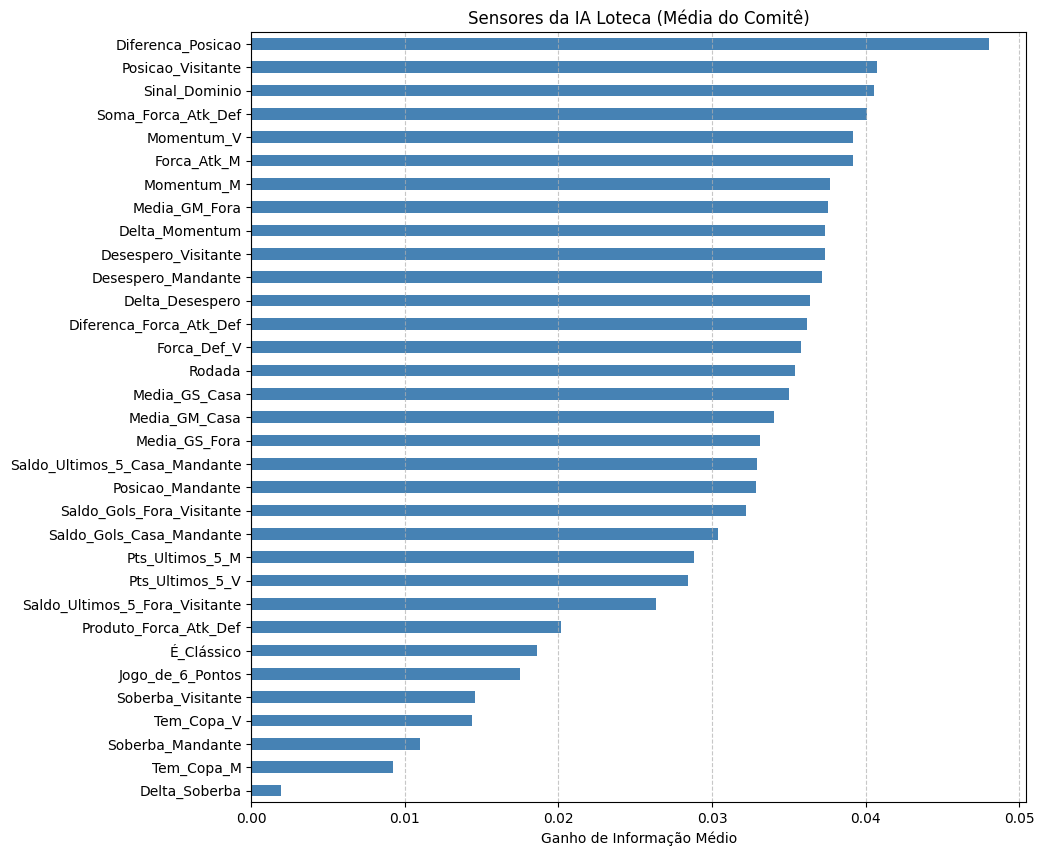

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Como o VotingClassifier não tem feature_importances_ direto, pegamos a média dos modelos internos
# Acessamos o índice [0] (XGB) e [1] (RF) que definimos no comitê
feat_imp_xgb = comite_loteca.estimators_[0].feature_importances_
feat_imp_rf = comite_loteca.estimators_[1].feature_importances_

# Média ponderada (ou simples) das importâncias
importancias_medias = (feat_imp_xgb + feat_imp_rf) / 2

plt.figure(figsize=(10, 10))
series_imp = pd.Series(importancias_medias, index=X.columns)
series_imp.nlargest(33).sort_values(ascending=True).plot(kind='barh', color='steelblue')
plt.title("Sensores da IA Loteca (Média do Comitê)")
plt.xlabel("Ganho de Informação Médio")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()